In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# training = pd.read_csv('Data/ab_wind_train_data.txt')
# testing = pd.read_csv('Data/ab_wind_test_data.txt')
# All data without null, 2.5m
data = pd.read_csv('Data\processed_ab_wind.csv')

C:\Users\PPL\AppData\Local\Temp\ipykernel_65228\2481163954.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data\processed_ab_wind.csv')


In [4]:
grouped_by_date_data = data.groupby('date')

In [5]:
np.bincount(grouped_by_date_data.size()).argmax() #32 stations is the max number of stations for most dates

32

In [6]:
size = grouped_by_date_data.size()

Text(0.5, 0, 'Number of stations')

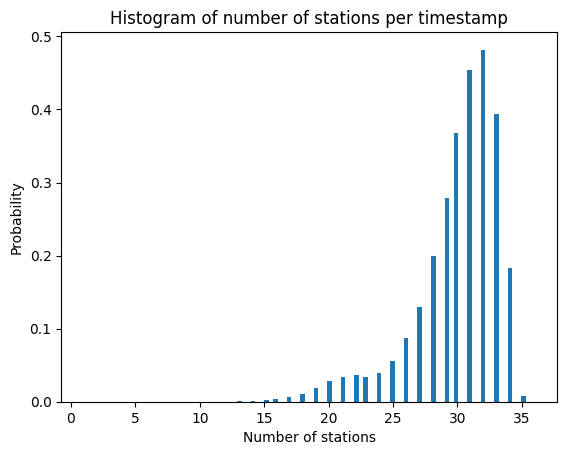

In [7]:
plt.hist(size, bins=100, density=True)
plt.title("Histogram of number of stations per timestamp")
plt.ylabel("Probability")
plt.xlabel("Number of stations")

In [8]:
number_of_stations_in_dates = [31, 32, 33, 34, 35] 
common_stations = []

for number in number_of_stations_in_dates:
    dates_with_major_stations = size.index[size == number]
    filtered_data = data.loc[data['date'].isin(dates_with_major_stations)]
    filtered_data_names = filtered_data.groupby('date')['name'].apply(list)
    filtered_data_names_list = filtered_data_names.values.tolist()
    res = list(reduce(lambda i, j: i & j, (set(x) for x in filtered_data_names_list[0:10])))
    
    common_stations.append(res)


In [9]:
common_station_names = list(reduce(lambda i, j: i & j, (set(x) for x in common_stations)))

In [10]:
dates_with_most_stations = size.index[size >= 31]

In [11]:
dates_with_most_stations

Index(['2014-05-28 14:00', '2014-05-28 16:00', '2014-05-28 17:00',
       '2014-05-29 11:00', '2014-05-29 19:00', '2014-05-30 02:00',
       '2014-05-30 11:00', '2014-05-31 14:00', '2014-05-31 19:00',
       '2014-05-31 20:00',
       ...
       '2023-09-14 11:00', '2023-09-14 12:00', '2023-09-14 13:00',
       '2023-09-14 14:00', '2023-09-14 15:00', '2023-09-14 16:00',
       '2023-09-14 17:00', '2023-09-14 18:00', '2023-09-14 19:00',
       '2023-09-14 20:00'],
      dtype='object', name='date', length=45590)

In [12]:
filtered_data = data.loc[data['date'].isin(dates_with_most_stations)]

In [16]:
filtered_data['name'].unique().shape

(38,)

In [17]:
teacher, student = train_test_split(dates_with_most_stations, test_size = 0.1)

In [18]:
#filtered_train_dates, filtered_test_dates = train_test_split(filtered_test_dates, test_size = 0.3)

In [19]:
filtered_teacher = filtered_data.loc[filtered_data['date'].isin(teacher) & filtered_data['name'].isin(common_station_names)]
filtered_student = filtered_data.loc[filtered_data['date'].isin(student) & filtered_data['name'].isin(common_station_names)]

In [22]:
filtered_student['name'].unique().shape

(25,)

In [40]:
# filtered_test.to_csv('Data\processed_ab_student.csv', sep = ',', index = False)
# filtered_train.to_csv('Data\processed_ab_teacher.csv', sep = ',', index = False)

In [42]:
train_dates, test_dates = train_test_split(teacher, test_size = 0.3)

In [45]:
train_data = filtered_teacher.loc[filtered_teacher['date'].isin(train_dates) & filtered_teacher['name'].isin(common_station_names)]
test_data = filtered_teacher.loc[filtered_teacher['date'].isin(test_dates) & filtered_teacher['name'].isin(common_station_names)]

In [48]:
# train_data.to_csv('Data\processed_ab_teacher_train.txt', sep = ',', index = False)
# test_data.to_csv('Data\processed_ab_teacher_test.txt', sep = ',', index = False)

In [98]:
train_data = pd.read_csv('Data\processed_ab_teacher_train.txt')
test_data = pd.read_csv('Data\processed_ab_teacher_test.txt')

C:\Users\PPL\AppData\Local\Temp\ipykernel_65228\2417379012.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_temp = pd.read_csv('Data\processed_ab_teacher_train.txt')


In [100]:
train_data_temp['date'].unique().shape

(28721,)

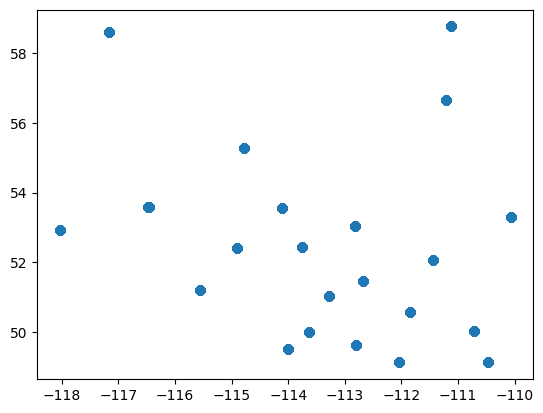

In [86]:
plt.scatter(x=train_data['longitude'], y=train_data['latitude'])
plt.show()

In [88]:
train_data_dates = train_data['date'].unique()

In [90]:
train_data_dates.shape

(28721,)

In [91]:
train_data_dates,_ = train_test_split(train_data_dates, test_size = 0.4)

In [92]:
train_data = train_data.loc[train_data['date'].isin(train_data_dates)]

In [102]:
train_data['date'].unique().shape

(17232,)

In [103]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [104]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    # Fcm hyperparameters
    FCM_Nc = 100
    FCM_m = 2
    tol = 1e-5
    max_iter = 200
        
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        qs.append(q)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break
    # 模型训练
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    plt.figure(figsize=(8,8))    
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.title('TS model prediction vs true value for testing data')
    #plt.legend()
    
    plt.figure(figsize=(8,8))
    plt.plot(qs)
    #plt.show()

    return rmse_train, rmse_validation


In [105]:
def linear_model(train_x, train_y, validation_x, validation_y):
    reg = LinearRegression().fit(train_x, train_y)
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False)

In [106]:
def build_neural_network_model():
    model = models.Sequential()
    
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1))    
    
    return model

In [107]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model

In [108]:
# Filter and process the data suitable for the training/testing
def generate_exp_data(raw_data, number_of_stations, max_threshold_distance, min_threshold_distance):
    # First fitler the data based on the settings
    x = []
    y = []

    for station in raw_data['name'].unique():
        features, target = Data_utils.generate_data(
            raw_data, 
            station, 
            number_of_stations, 
            max_threshold_distance, 
            min_threshold_distance
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            x.append(np_features)
            y.append(np_target)
    
    return x, y

In [109]:
# hyperparameters for the expeirment
number_of_neighbour_stations = [1,2,3,4,5,6, 7, 8, 9, 10]
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 5
# General hyperparameter
max_threshold_distance = 100000 #km
min_threshold_distance = 0 #km

# Results containers
training_results = []
validation_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values, training_data):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    j = 1
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # First fitler the data based on the settings
        train_x, train_y = generate_exp_data(training_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
        
        # After all stations are filtered, flatten the data into a huge list        
        flatten_x = np.array([data for sublist in train_x for data in sublist])
        flatten_y = np.array([data for sublist in train_y for data in sublist])
        
        temp_x = pd.DataFrame(flatten_x)
        temp_x.to_csv(f"Data\exp\{j}x.csv")
        temp_y = pd.DataFrame(flatten_y)
        temp_y.to_csv(f"Data\exp\{j}y.csv")
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        validation_results_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i, (train_index, val_index) in enumerate(kf.split(flatten_x)):
            split_train_x = flatten_x[train_index]
            split_train_y = flatten_y[train_index]

            split_val_x = flatten_x[val_index]
            split_val_y = flatten_y[val_index]
            # Normalize the input
            split_train_x, split_val_x = preprocess_data(split_train_x, split_val_x)            
            # Linear model
            li_train_rmse, li_val_rmse = linear_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            validation_results_fold.append({'linear_val' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            validation_results_fold.append({'fcm_val' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, _ = neural_network_model(split_train_x, split_train_y, split_val_x , split_val_y)
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            validation_results_fold.append({'nn_val' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        validation_results.append(validation_results_fold)
        nn_histories.append(nn_history_fold)
        j = j+1
        
        

linear train
7.591591226812526
linear_validation
7.6147214290141365
FCM traning RMSE: 7.485164959003661
FCM val RMSE: 7.511998001235346
Epoch 1/50
9518/9518 [==============================] - 29s 3ms/step - loss: 64.8326 - root_mean_squared_error: 8.0519 - val_loss: 56.2346 - val_root_mean_squared_error: 7.4990
Epoch 2/50
9518/9518 [==============================] - 30s 3ms/step - loss: 54.9040 - root_mean_squared_error: 7.4097 - val_loss: 54.6794 - val_root_mean_squared_error: 7.3946
Epoch 3/50
9518/9518 [==============================] - 28s 3ms/step - loss: 53.6065 - root_mean_squared_error: 7.3216 - val_loss: 53.7124 - val_root_mean_squared_error: 7.3289
Epoch 4/50
9518/9518 [==============================] - 29s 3ms/step - loss: 52.6960 - root_mean_squared_error: 7.2592 - val_loss: 52.7065 - val_root_mean_squared_error: 7.2599
Epoch 5/50
9518/9518 [==============================] - 31s 3ms/step - loss: 52.0319 - root_mean_squared_error: 7.2133 - val_loss: 52.1279 - val_root_mean_s

9518/9518 [==============================] - 32s 3ms/step - loss: 43.9599 - root_mean_squared_error: 6.6302 - val_loss: 44.5030 - val_root_mean_squared_error: 6.6711
Epoch 47/50
9518/9518 [==============================] - 31s 3ms/step - loss: 43.9303 - root_mean_squared_error: 6.6280 - val_loss: 44.3916 - val_root_mean_squared_error: 6.6627
Epoch 48/50
9518/9518 [==============================] - 32s 3ms/step - loss: 43.9031 - root_mean_squared_error: 6.6259 - val_loss: 44.3888 - val_root_mean_squared_error: 6.6625
Epoch 49/50
9518/9518 [==============================] - 32s 3ms/step - loss: 43.8823 - root_mean_squared_error: 6.6244 - val_loss: 44.3142 - val_root_mean_squared_error: 6.6569
Epoch 50/50
9518/9518 [==============================] - 31s 3ms/step - loss: 43.8580 - root_mean_squared_error: 6.6225 - val_loss: 44.4381 - val_root_mean_squared_error: 6.6662
linear train
7.591118945482113
linear_validation
7.616502300808541
FCM traning RMSE: 7.486032052188108
FCM val RMSE: 7.510

9518/9518 [==============================] - 31s 3ms/step - loss: 44.2423 - root_mean_squared_error: 6.6515 - val_loss: 44.9341 - val_root_mean_squared_error: 6.7033
Epoch 42/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.2291 - root_mean_squared_error: 6.6505 - val_loss: 44.8333 - val_root_mean_squared_error: 6.6958
Epoch 43/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.2021 - root_mean_squared_error: 6.6485 - val_loss: 44.8572 - val_root_mean_squared_error: 6.6976
Epoch 44/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.1753 - root_mean_squared_error: 6.6464 - val_loss: 44.8178 - val_root_mean_squared_error: 6.6946
Epoch 45/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.1460 - root_mean_squared_error: 6.6442 - val_loss: 44.7913 - val_root_mean_squared_error: 6.6926
Epoch 46/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.1127 - root_mean_squared_error: 6.6417 - 

9518/9518 [==============================] - 31s 3ms/step - loss: 44.5560 - root_mean_squared_error: 6.6750 - val_loss: 44.0625 - val_root_mean_squared_error: 6.6380
Epoch 37/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.5433 - root_mean_squared_error: 6.6741 - val_loss: 43.9070 - val_root_mean_squared_error: 6.6262
Epoch 38/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.5079 - root_mean_squared_error: 6.6714 - val_loss: 44.0292 - val_root_mean_squared_error: 6.6354
Epoch 39/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.4944 - root_mean_squared_error: 6.6704 - val_loss: 44.0294 - val_root_mean_squared_error: 6.6355
Epoch 40/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.4751 - root_mean_squared_error: 6.6690 - val_loss: 43.9499 - val_root_mean_squared_error: 6.6295
Epoch 41/50
9518/9518 [==============================] - 33s 3ms/step - loss: 44.4652 - root_mean_squared_error: 6.6682 - 

9518/9518 [==============================] - 32s 3ms/step - loss: 44.6782 - root_mean_squared_error: 6.6842 - val_loss: 44.4398 - val_root_mean_squared_error: 6.6663
Epoch 32/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.6167 - root_mean_squared_error: 6.6796 - val_loss: 44.4146 - val_root_mean_squared_error: 6.6644
Epoch 33/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.5688 - root_mean_squared_error: 6.6760 - val_loss: 44.4003 - val_root_mean_squared_error: 6.6634
Epoch 34/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.5127 - root_mean_squared_error: 6.6718 - val_loss: 44.3106 - val_root_mean_squared_error: 6.6566
Epoch 35/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.4681 - root_mean_squared_error: 6.6684 - val_loss: 44.2139 - val_root_mean_squared_error: 6.6493
Epoch 36/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.4227 - root_mean_squared_error: 6.6650 - 

9518/9518 [==============================] - 32s 3ms/step - loss: 44.8907 - root_mean_squared_error: 6.7001 - val_loss: 44.8614 - val_root_mean_squared_error: 6.6979
Epoch 27/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.8381 - root_mean_squared_error: 6.6961 - val_loss: 44.6446 - val_root_mean_squared_error: 6.6817
Epoch 28/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.7535 - root_mean_squared_error: 6.6898 - val_loss: 44.6831 - val_root_mean_squared_error: 6.6845
Epoch 29/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.6769 - root_mean_squared_error: 6.6841 - val_loss: 44.4734 - val_root_mean_squared_error: 6.6688
Epoch 30/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.6214 - root_mean_squared_error: 6.6799 - val_loss: 44.6108 - val_root_mean_squared_error: 6.6791
Epoch 31/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.5589 - root_mean_squared_error: 6.6752 - 

9052/9052 [==============================] - 30s 3ms/step - loss: 39.1479 - root_mean_squared_error: 6.2568 - val_loss: 39.1383 - val_root_mean_squared_error: 6.2561
Epoch 22/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.1013 - root_mean_squared_error: 6.2531 - val_loss: 39.0198 - val_root_mean_squared_error: 6.2466
Epoch 23/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.0637 - root_mean_squared_error: 6.2501 - val_loss: 38.8823 - val_root_mean_squared_error: 6.2356
Epoch 24/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.0188 - root_mean_squared_error: 6.2465 - val_loss: 39.0370 - val_root_mean_squared_error: 6.2480
Epoch 25/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.9807 - root_mean_squared_error: 6.2435 - val_loss: 39.0023 - val_root_mean_squared_error: 6.2452
Epoch 26/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.9521 - root_mean_squared_error: 6.2412 - 

9052/9052 [==============================] - 30s 3ms/step - loss: 39.4149 - root_mean_squared_error: 6.2781 - val_loss: 39.0781 - val_root_mean_squared_error: 6.2512
Epoch 17/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.3360 - root_mean_squared_error: 6.2718 - val_loss: 39.0121 - val_root_mean_squared_error: 6.2460
Epoch 18/50
9052/9052 [==============================] - 31s 3ms/step - loss: 39.2900 - root_mean_squared_error: 6.2682 - val_loss: 38.9272 - val_root_mean_squared_error: 6.2392
Epoch 19/50
9052/9052 [==============================] - 31s 3ms/step - loss: 39.2316 - root_mean_squared_error: 6.2635 - val_loss: 38.8706 - val_root_mean_squared_error: 6.2346
Epoch 20/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.1901 - root_mean_squared_error: 6.2602 - val_loss: 38.8815 - val_root_mean_squared_error: 6.2355
Epoch 21/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.1383 - root_mean_squared_error: 6.2561 - 

9052/9052 [==============================] - 31s 3ms/step - loss: 40.0048 - root_mean_squared_error: 6.3249 - val_loss: 39.9819 - val_root_mean_squared_error: 6.3231
Epoch 12/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.8735 - root_mean_squared_error: 6.3146 - val_loss: 39.8516 - val_root_mean_squared_error: 6.3128
Epoch 13/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.7344 - root_mean_squared_error: 6.3035 - val_loss: 39.9138 - val_root_mean_squared_error: 6.3177
Epoch 14/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.5862 - root_mean_squared_error: 6.2918 - val_loss: 39.7339 - val_root_mean_squared_error: 6.3035
Epoch 15/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.4870 - root_mean_squared_error: 6.2839 - val_loss: 39.5392 - val_root_mean_squared_error: 6.2880
Epoch 16/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.3676 - root_mean_squared_error: 6.2744 - 

9052/9052 [==============================] - 29s 3ms/step - loss: 40.7501 - root_mean_squared_error: 6.3836 - val_loss: 40.9543 - val_root_mean_squared_error: 6.3996
Epoch 7/50
9052/9052 [==============================] - 30s 3ms/step - loss: 40.4203 - root_mean_squared_error: 6.3577 - val_loss: 40.6864 - val_root_mean_squared_error: 6.3786
Epoch 8/50
9052/9052 [==============================] - 30s 3ms/step - loss: 40.1881 - root_mean_squared_error: 6.3394 - val_loss: 40.6386 - val_root_mean_squared_error: 6.3748
Epoch 9/50
9052/9052 [==============================] - 30s 3ms/step - loss: 40.0072 - root_mean_squared_error: 6.3251 - val_loss: 40.2973 - val_root_mean_squared_error: 6.3480
Epoch 10/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.8446 - root_mean_squared_error: 6.3123 - val_loss: 40.2438 - val_root_mean_squared_error: 6.3438
Epoch 11/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.7196 - root_mean_squared_error: 6.3023 - val

9052/9052 [==============================] - 31s 3ms/step - loss: 59.6862 - root_mean_squared_error: 7.7257 - val_loss: 47.7938 - val_root_mean_squared_error: 6.9133
Epoch 2/50
9052/9052 [==============================] - 30s 3ms/step - loss: 45.9106 - root_mean_squared_error: 6.7757 - val_loss: 44.7712 - val_root_mean_squared_error: 6.6911
Epoch 3/50
9052/9052 [==============================] - 30s 3ms/step - loss: 43.6514 - root_mean_squared_error: 6.6069 - val_loss: 42.9244 - val_root_mean_squared_error: 6.5517
Epoch 4/50
9052/9052 [==============================] - 30s 3ms/step - loss: 42.4873 - root_mean_squared_error: 6.5182 - val_loss: 42.1780 - val_root_mean_squared_error: 6.4945
Epoch 5/50
9052/9052 [==============================] - 31s 3ms/step - loss: 41.7748 - root_mean_squared_error: 6.4633 - val_loss: 41.5024 - val_root_mean_squared_error: 6.4422
Epoch 6/50
9052/9052 [==============================] - 30s 3ms/step - loss: 41.2112 - root_mean_squared_error: 6.4196 - val_l

9052/9052 [==============================] - 30s 3ms/step - loss: 38.3179 - root_mean_squared_error: 6.1901 - val_loss: 38.6795 - val_root_mean_squared_error: 6.2193
Epoch 48/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.3177 - root_mean_squared_error: 6.1901 - val_loss: 38.7087 - val_root_mean_squared_error: 6.2216
Epoch 49/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.2928 - root_mean_squared_error: 6.1881 - val_loss: 38.6143 - val_root_mean_squared_error: 6.2140
Epoch 50/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.2887 - root_mean_squared_error: 6.1878 - val_loss: 38.5234 - val_root_mean_squared_error: 6.2067
linear train
7.08922811265905
linear_validation
7.032529116730648
FCM traning RMSE: 6.600264524614885
FCM val RMSE: 6.753103234607507


C:\Users\PPL\AppData\Local\Temp\ipykernel_65228\282031044.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


Epoch 1/50
8695/8695 [==============================] - 29s 3ms/step - loss: 55.1055 - root_mean_squared_error: 7.4233 - val_loss: 41.5870 - val_root_mean_squared_error: 6.4488
Epoch 2/50
8695/8695 [==============================] - 29s 3ms/step - loss: 40.9425 - root_mean_squared_error: 6.3986 - val_loss: 39.8890 - val_root_mean_squared_error: 6.3158
Epoch 3/50
8695/8695 [==============================] - 29s 3ms/step - loss: 39.6651 - root_mean_squared_error: 6.2980 - val_loss: 38.9228 - val_root_mean_squared_error: 6.2388
Epoch 4/50
8695/8695 [==============================] - 30s 3ms/step - loss: 38.9001 - root_mean_squared_error: 6.2370 - val_loss: 38.5816 - val_root_mean_squared_error: 6.2114
Epoch 5/50
8695/8695 [==============================] - 29s 3ms/step - loss: 38.3851 - root_mean_squared_error: 6.1956 - val_loss: 37.6779 - val_root_mean_squared_error: 6.1382
Epoch 6/50
8695/8695 [==============================] - 29s 3ms/step - loss: 37.9608 - root_mean_squared_error: 6.1

8695/8695 [==============================] - 29s 3ms/step - loss: 35.5553 - root_mean_squared_error: 5.9628 - val_loss: 35.2374 - val_root_mean_squared_error: 5.9361
Epoch 48/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.5505 - root_mean_squared_error: 5.9624 - val_loss: 35.0059 - val_root_mean_squared_error: 5.9166
Epoch 49/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.5402 - root_mean_squared_error: 5.9616 - val_loss: 35.3863 - val_root_mean_squared_error: 5.9486
Epoch 50/50
8695/8695 [==============================] - 30s 3ms/step - loss: 35.5283 - root_mean_squared_error: 5.9606 - val_loss: 35.0025 - val_root_mean_squared_error: 5.9163
linear train
7.071120133208736
linear_validation
7.105361544670555
FCM traning RMSE: 6.576805197377964
FCM val RMSE: 6.621981505382041
Epoch 1/50
8695/8695 [==============================] - 29s 3ms/step - loss: 54.9468 - root_mean_squared_error: 7.4126 - val_loss: 42.2399 - val_root_mean_squared_er

8695/8695 [==============================] - 28s 3ms/step - loss: 35.4157 - root_mean_squared_error: 5.9511 - val_loss: 36.1406 - val_root_mean_squared_error: 6.0117
Epoch 43/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3918 - root_mean_squared_error: 5.9491 - val_loss: 36.0988 - val_root_mean_squared_error: 6.0082
Epoch 44/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3806 - root_mean_squared_error: 5.9482 - val_loss: 36.1137 - val_root_mean_squared_error: 6.0095
Epoch 45/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3788 - root_mean_squared_error: 5.9480 - val_loss: 36.0824 - val_root_mean_squared_error: 6.0069
Epoch 46/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3549 - root_mean_squared_error: 5.9460 - val_loss: 36.1234 - val_root_mean_squared_error: 6.0103
Epoch 47/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3556 - root_mean_squared_error: 5.9461 - 

8695/8695 [==============================] - 28s 3ms/step - loss: 35.7970 - root_mean_squared_error: 5.9831 - val_loss: 35.7380 - val_root_mean_squared_error: 5.9781
Epoch 38/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7654 - root_mean_squared_error: 5.9804 - val_loss: 35.7183 - val_root_mean_squared_error: 5.9765
Epoch 39/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7501 - root_mean_squared_error: 5.9791 - val_loss: 35.6966 - val_root_mean_squared_error: 5.9747
Epoch 40/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7328 - root_mean_squared_error: 5.9777 - val_loss: 35.6090 - val_root_mean_squared_error: 5.9673
Epoch 41/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7224 - root_mean_squared_error: 5.9768 - val_loss: 35.8214 - val_root_mean_squared_error: 5.9851
Epoch 42/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7007 - root_mean_squared_error: 5.9750 - 

8695/8695 [==============================] - 30s 3ms/step - loss: 35.7944 - root_mean_squared_error: 5.9828 - val_loss: 35.8928 - val_root_mean_squared_error: 5.9911
Epoch 33/50
8695/8695 [==============================] - 30s 3ms/step - loss: 35.7648 - root_mean_squared_error: 5.9804 - val_loss: 35.8084 - val_root_mean_squared_error: 5.9840
Epoch 34/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.7551 - root_mean_squared_error: 5.9796 - val_loss: 35.7804 - val_root_mean_squared_error: 5.9817
Epoch 35/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7196 - root_mean_squared_error: 5.9766 - val_loss: 35.9877 - val_root_mean_squared_error: 5.9990
Epoch 36/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.7026 - root_mean_squared_error: 5.9752 - val_loss: 35.7562 - val_root_mean_squared_error: 5.9796
Epoch 37/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.6882 - root_mean_squared_error: 5.9740 - 

8695/8695 [==============================] - 29s 3ms/step - loss: 35.7360 - root_mean_squared_error: 5.9780 - val_loss: 35.9983 - val_root_mean_squared_error: 5.9999
Epoch 28/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7007 - root_mean_squared_error: 5.9750 - val_loss: 36.0367 - val_root_mean_squared_error: 6.0031
Epoch 29/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.6820 - root_mean_squared_error: 5.9734 - val_loss: 36.0272 - val_root_mean_squared_error: 6.0023
Epoch 30/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.6656 - root_mean_squared_error: 5.9721 - val_loss: 35.9469 - val_root_mean_squared_error: 5.9956
Epoch 31/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.6367 - root_mean_squared_error: 5.9696 - val_loss: 35.9383 - val_root_mean_squared_error: 5.9949
Epoch 32/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.6139 - root_mean_squared_error: 5.9677 - 

8238/8238 [==============================] - 13s 2ms/step - loss: 35.5215 - root_mean_squared_error: 5.9600 - val_loss: 35.7877 - val_root_mean_squared_error: 5.9823
Epoch 23/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.4753 - root_mean_squared_error: 5.9561 - val_loss: 35.7605 - val_root_mean_squared_error: 5.9800
Epoch 24/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.4354 - root_mean_squared_error: 5.9528 - val_loss: 35.8606 - val_root_mean_squared_error: 5.9884
Epoch 25/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.4255 - root_mean_squared_error: 5.9519 - val_loss: 35.8881 - val_root_mean_squared_error: 5.9907
Epoch 26/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.3804 - root_mean_squared_error: 5.9481 - val_loss: 35.6917 - val_root_mean_squared_error: 5.9743
Epoch 27/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.3715 - root_mean_squared_error: 5.9474 - 

8238/8238 [==============================] - 13s 2ms/step - loss: 35.8303 - root_mean_squared_error: 5.9858 - val_loss: 35.6520 - val_root_mean_squared_error: 5.9709
Epoch 18/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.8039 - root_mean_squared_error: 5.9836 - val_loss: 35.4789 - val_root_mean_squared_error: 5.9564
Epoch 19/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.7290 - root_mean_squared_error: 5.9774 - val_loss: 35.4587 - val_root_mean_squared_error: 5.9547
Epoch 20/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.6852 - root_mean_squared_error: 5.9737 - val_loss: 35.4446 - val_root_mean_squared_error: 5.9535
Epoch 21/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.6537 - root_mean_squared_error: 5.9711 - val_loss: 35.2454 - val_root_mean_squared_error: 5.9368
Epoch 22/50
8238/8238 [==============================] - 13s 2ms/step - loss: 35.6186 - root_mean_squared_error: 5.9681 - 

8238/8238 [==============================] - 25s 3ms/step - loss: 35.8500 - root_mean_squared_error: 5.9875 - val_loss: 36.5182 - val_root_mean_squared_error: 6.0430
Epoch 13/50
8238/8238 [==============================] - 24s 3ms/step - loss: 35.7519 - root_mean_squared_error: 5.9793 - val_loss: 36.2846 - val_root_mean_squared_error: 6.0237
Epoch 14/50
8238/8238 [==============================] - 24s 3ms/step - loss: 35.7161 - root_mean_squared_error: 5.9763 - val_loss: 36.3779 - val_root_mean_squared_error: 6.0314
Epoch 15/50
8238/8238 [==============================] - 25s 3ms/step - loss: 35.6489 - root_mean_squared_error: 5.9707 - val_loss: 36.1739 - val_root_mean_squared_error: 6.0145
Epoch 16/50
8238/8238 [==============================] - 24s 3ms/step - loss: 35.5671 - root_mean_squared_error: 5.9638 - val_loss: 36.2643 - val_root_mean_squared_error: 6.0220
Epoch 17/50
8238/8238 [==============================] - 24s 3ms/step - loss: 35.5144 - root_mean_squared_error: 5.9594 - 

8238/8238 [==============================] - 26s 3ms/step - loss: 36.6139 - root_mean_squared_error: 6.0509 - val_loss: 36.9662 - val_root_mean_squared_error: 6.0800
Epoch 8/50
8238/8238 [==============================] - 24s 3ms/step - loss: 36.3979 - root_mean_squared_error: 6.0331 - val_loss: 36.7803 - val_root_mean_squared_error: 6.0647
Epoch 9/50
8238/8238 [==============================] - 25s 3ms/step - loss: 36.1802 - root_mean_squared_error: 6.0150 - val_loss: 36.4862 - val_root_mean_squared_error: 6.0404
Epoch 10/50
8238/8238 [==============================] - 27s 3ms/step - loss: 36.0277 - root_mean_squared_error: 6.0023 - val_loss: 36.4350 - val_root_mean_squared_error: 6.0361
Epoch 11/50
8238/8238 [==============================] - 26s 3ms/step - loss: 35.8914 - root_mean_squared_error: 5.9909 - val_loss: 36.3874 - val_root_mean_squared_error: 6.0322
Epoch 12/50
8238/8238 [==============================] - 26s 3ms/step - loss: 35.8047 - root_mean_squared_error: 5.9837 - va

8238/8238 [==============================] - 26s 3ms/step - loss: 40.0260 - root_mean_squared_error: 6.3266 - val_loss: 38.4407 - val_root_mean_squared_error: 6.2001
Epoch 3/50
8238/8238 [==============================] - 27s 3ms/step - loss: 38.4768 - root_mean_squared_error: 6.2030 - val_loss: 37.4772 - val_root_mean_squared_error: 6.1219
Epoch 4/50
8238/8238 [==============================] - 27s 3ms/step - loss: 37.6805 - root_mean_squared_error: 6.1384 - val_loss: 37.0763 - val_root_mean_squared_error: 6.0890
Epoch 5/50
8238/8238 [==============================] - 25s 3ms/step - loss: 37.2308 - root_mean_squared_error: 6.1017 - val_loss: 36.5631 - val_root_mean_squared_error: 6.0467
Epoch 6/50
8238/8238 [==============================] - 24s 3ms/step - loss: 36.9125 - root_mean_squared_error: 6.0756 - val_loss: 36.3105 - val_root_mean_squared_error: 6.0258
Epoch 7/50
8238/8238 [==============================] - 24s 3ms/step - loss: 36.6415 - root_mean_squared_error: 6.0532 - val_l

8238/8238 [==============================] - 15s 2ms/step - loss: 34.9906 - root_mean_squared_error: 5.9153 - val_loss: 34.7135 - val_root_mean_squared_error: 5.8918
Epoch 49/50
8238/8238 [==============================] - 15s 2ms/step - loss: 34.9682 - root_mean_squared_error: 5.9134 - val_loss: 34.7056 - val_root_mean_squared_error: 5.8911
Epoch 50/50
8238/8238 [==============================] - 13s 2ms/step - loss: 34.9652 - root_mean_squared_error: 5.9131 - val_loss: 35.2476 - val_root_mean_squared_error: 5.9370
linear train
6.952264230547863
linear_validation
6.911202673940007
FCM traning RMSE: 6.7908863335823195
FCM val RMSE: 6.754819284449996
Epoch 1/50
7627/7627 [==============================] - 13s 2ms/step - loss: 57.6498 - root_mean_squared_error: 7.5927 - val_loss: 41.6290 - val_root_mean_squared_error: 6.4521
Epoch 2/50
7627/7627 [==============================] - 12s 2ms/step - loss: 40.6909 - root_mean_squared_error: 6.3789 - val_loss: 39.1746 - val_root_mean_squared_er

7627/7627 [==============================] - 12s 2ms/step - loss: 35.2295 - root_mean_squared_error: 5.9354 - val_loss: 35.1071 - val_root_mean_squared_error: 5.9251
Epoch 44/50
7627/7627 [==============================] - 12s 2ms/step - loss: 35.1913 - root_mean_squared_error: 5.9322 - val_loss: 35.0532 - val_root_mean_squared_error: 5.9206
Epoch 45/50
7627/7627 [==============================] - 12s 2ms/step - loss: 35.2112 - root_mean_squared_error: 5.9339 - val_loss: 35.2684 - val_root_mean_squared_error: 5.9387
Epoch 46/50
7627/7627 [==============================] - 11s 1ms/step - loss: 35.1861 - root_mean_squared_error: 5.9318 - val_loss: 35.1584 - val_root_mean_squared_error: 5.9295
Epoch 47/50
7627/7627 [==============================] - 11s 1ms/step - loss: 35.1759 - root_mean_squared_error: 5.9309 - val_loss: 35.0273 - val_root_mean_squared_error: 5.9184
Epoch 48/50
7627/7627 [==============================] - 12s 2ms/step - loss: 35.1697 - root_mean_squared_error: 5.9304 - 

7627/7627 [==============================] - 12s 2ms/step - loss: 34.7738 - root_mean_squared_error: 5.8969 - val_loss: 35.4502 - val_root_mean_squared_error: 5.9540
Epoch 39/50
7627/7627 [==============================] - 12s 2ms/step - loss: 34.7625 - root_mean_squared_error: 5.8960 - val_loss: 35.4467 - val_root_mean_squared_error: 5.9537
Epoch 40/50
7627/7627 [==============================] - 12s 2ms/step - loss: 34.7517 - root_mean_squared_error: 5.8951 - val_loss: 35.4518 - val_root_mean_squared_error: 5.9541
Epoch 41/50
7627/7627 [==============================] - 12s 2ms/step - loss: 34.7228 - root_mean_squared_error: 5.8926 - val_loss: 35.4058 - val_root_mean_squared_error: 5.9503
Epoch 42/50
7627/7627 [==============================] - 12s 2ms/step - loss: 34.7217 - root_mean_squared_error: 5.8925 - val_loss: 35.4760 - val_root_mean_squared_error: 5.9562
Epoch 43/50
7627/7627 [==============================] - 12s 2ms/step - loss: 34.7060 - root_mean_squared_error: 5.8912 - 

7627/7627 [==============================] - 20s 3ms/step - loss: 34.9342 - root_mean_squared_error: 5.9105 - val_loss: 35.6232 - val_root_mean_squared_error: 5.9685
Epoch 34/50
7627/7627 [==============================] - 20s 3ms/step - loss: 34.8956 - root_mean_squared_error: 5.9072 - val_loss: 35.5816 - val_root_mean_squared_error: 5.9650
Epoch 35/50
7627/7627 [==============================] - 21s 3ms/step - loss: 34.8993 - root_mean_squared_error: 5.9076 - val_loss: 35.4241 - val_root_mean_squared_error: 5.9518
Epoch 36/50
7627/7627 [==============================] - 21s 3ms/step - loss: 34.8612 - root_mean_squared_error: 5.9043 - val_loss: 35.4379 - val_root_mean_squared_error: 5.9530
Epoch 37/50
7627/7627 [==============================] - 20s 3ms/step - loss: 34.8446 - root_mean_squared_error: 5.9029 - val_loss: 35.5867 - val_root_mean_squared_error: 5.9655
Epoch 38/50
7627/7627 [==============================] - 20s 3ms/step - loss: 34.8426 - root_mean_squared_error: 5.9028 - 

7627/7627 [==============================] - 21s 3ms/step - loss: 35.1776 - root_mean_squared_error: 5.9311 - val_loss: 35.6325 - val_root_mean_squared_error: 5.9693
Epoch 29/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.1592 - root_mean_squared_error: 5.9295 - val_loss: 35.6167 - val_root_mean_squared_error: 5.9680
Epoch 30/50
7627/7627 [==============================] - 20s 3ms/step - loss: 35.1398 - root_mean_squared_error: 5.9279 - val_loss: 35.5543 - val_root_mean_squared_error: 5.9627
Epoch 31/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.1086 - root_mean_squared_error: 5.9253 - val_loss: 35.6457 - val_root_mean_squared_error: 5.9704
Epoch 32/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.0872 - root_mean_squared_error: 5.9234 - val_loss: 35.5406 - val_root_mean_squared_error: 5.9616
Epoch 33/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.0706 - root_mean_squared_error: 5.9220 - 

7627/7627 [==============================] - 21s 3ms/step - loss: 35.4834 - root_mean_squared_error: 5.9568 - val_loss: 35.3625 - val_root_mean_squared_error: 5.9466
Epoch 24/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.4456 - root_mean_squared_error: 5.9536 - val_loss: 35.2615 - val_root_mean_squared_error: 5.9381
Epoch 25/50
7627/7627 [==============================] - 23s 3ms/step - loss: 35.4178 - root_mean_squared_error: 5.9513 - val_loss: 35.4503 - val_root_mean_squared_error: 5.9540
Epoch 26/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.3923 - root_mean_squared_error: 5.9491 - val_loss: 35.3139 - val_root_mean_squared_error: 5.9425
Epoch 27/50
7627/7627 [==============================] - 21s 3ms/step - loss: 35.3645 - root_mean_squared_error: 5.9468 - val_loss: 35.3468 - val_root_mean_squared_error: 5.9453
Epoch 28/50
7627/7627 [==============================] - 23s 3ms/step - loss: 35.3461 - root_mean_squared_error: 5.9453 - 

7320/7320 [==============================] - 20s 3ms/step - loss: 34.6409 - root_mean_squared_error: 5.8857 - val_loss: 35.3298 - val_root_mean_squared_error: 5.9439
Epoch 19/50
7320/7320 [==============================] - 19s 3ms/step - loss: 34.6383 - root_mean_squared_error: 5.8854 - val_loss: 35.1960 - val_root_mean_squared_error: 5.9326
Epoch 20/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.6018 - root_mean_squared_error: 5.8823 - val_loss: 35.0953 - val_root_mean_squared_error: 5.9241
Epoch 21/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.5382 - root_mean_squared_error: 5.8769 - val_loss: 35.2020 - val_root_mean_squared_error: 5.9331
Epoch 22/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.5273 - root_mean_squared_error: 5.8760 - val_loss: 35.0326 - val_root_mean_squared_error: 5.9188
Epoch 23/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.5066 - root_mean_squared_error: 5.8742 - 

7320/7320 [==============================] - 20s 3ms/step - loss: 35.0582 - root_mean_squared_error: 5.9210 - val_loss: 35.9896 - val_root_mean_squared_error: 5.9991
Epoch 14/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.9771 - root_mean_squared_error: 5.9141 - val_loss: 35.9939 - val_root_mean_squared_error: 5.9995
Epoch 15/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.9197 - root_mean_squared_error: 5.9093 - val_loss: 35.9715 - val_root_mean_squared_error: 5.9976
Epoch 16/50
7320/7320 [==============================] - 19s 3ms/step - loss: 34.8458 - root_mean_squared_error: 5.9030 - val_loss: 35.8377 - val_root_mean_squared_error: 5.9865
Epoch 17/50
7320/7320 [==============================] - 19s 3ms/step - loss: 34.8120 - root_mean_squared_error: 5.9002 - val_loss: 35.8157 - val_root_mean_squared_error: 5.9846
Epoch 18/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.7497 - root_mean_squared_error: 5.8949 - 

7320/7320 [==============================] - 20s 3ms/step - loss: 35.7232 - root_mean_squared_error: 5.9769 - val_loss: 35.3554 - val_root_mean_squared_error: 5.9460
Epoch 9/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.5554 - root_mean_squared_error: 5.9628 - val_loss: 35.4146 - val_root_mean_squared_error: 5.9510
Epoch 10/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.4557 - root_mean_squared_error: 5.9545 - val_loss: 35.2083 - val_root_mean_squared_error: 5.9337
Epoch 11/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.3867 - root_mean_squared_error: 5.9487 - val_loss: 34.9583 - val_root_mean_squared_error: 5.9126
Epoch 12/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.2916 - root_mean_squared_error: 5.9407 - val_loss: 35.0634 - val_root_mean_squared_error: 5.9214
Epoch 13/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.2079 - root_mean_squared_error: 5.9336 - v

7320/7320 [==============================] - 20s 3ms/step - loss: 37.5494 - root_mean_squared_error: 6.1278 - val_loss: 36.7109 - val_root_mean_squared_error: 6.0590
Epoch 4/50
7320/7320 [==============================] - 20s 3ms/step - loss: 36.8155 - root_mean_squared_error: 6.0676 - val_loss: 36.3179 - val_root_mean_squared_error: 6.0264
Epoch 5/50
7320/7320 [==============================] - 20s 3ms/step - loss: 36.3530 - root_mean_squared_error: 6.0293 - val_loss: 35.9349 - val_root_mean_squared_error: 5.9946
Epoch 6/50
7320/7320 [==============================] - 20s 3ms/step - loss: 36.0126 - root_mean_squared_error: 6.0011 - val_loss: 35.5678 - val_root_mean_squared_error: 5.9639
Epoch 7/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.7767 - root_mean_squared_error: 5.9814 - val_loss: 35.2133 - val_root_mean_squared_error: 5.9341
Epoch 8/50
7320/7320 [==============================] - 20s 3ms/step - loss: 35.5669 - root_mean_squared_error: 5.9638 - val_l

7320/7320 [==============================] - 20s 3ms/step - loss: 34.2119 - root_mean_squared_error: 5.8491 - val_loss: 34.2705 - val_root_mean_squared_error: 5.8541
Epoch 50/50
7320/7320 [==============================] - 20s 3ms/step - loss: 34.1710 - root_mean_squared_error: 5.8456 - val_loss: 34.3106 - val_root_mean_squared_error: 5.8575
linear train
6.778067821009797
linear_validation
6.81319847709117
FCM traning RMSE: 6.731003974252832
FCM val RMSE: 6.766061822199475
Epoch 1/50
7320/7320 [==============================] - 20s 3ms/step - loss: 55.2596 - root_mean_squared_error: 7.4337 - val_loss: 39.9361 - val_root_mean_squared_error: 6.3195
Epoch 2/50
7320/7320 [==============================] - 20s 3ms/step - loss: 38.4470 - root_mean_squared_error: 6.2006 - val_loss: 37.6409 - val_root_mean_squared_error: 6.1352
Epoch 3/50
7320/7320 [==============================] - 20s 3ms/step - loss: 37.0107 - root_mean_squared_error: 6.0836 - val_loss: 36.6190 - val_root_mean_squared_error

7320/7320 [==============================] - 19s 3ms/step - loss: 34.2692 - root_mean_squared_error: 5.8540 - val_loss: 34.8058 - val_root_mean_squared_error: 5.8996
Epoch 45/50
7320/7320 [==============================] - 14s 2ms/step - loss: 34.2535 - root_mean_squared_error: 5.8526 - val_loss: 34.7567 - val_root_mean_squared_error: 5.8955
Epoch 46/50
7320/7320 [==============================] - 12s 2ms/step - loss: 34.2442 - root_mean_squared_error: 5.8519 - val_loss: 34.7463 - val_root_mean_squared_error: 5.8946
Epoch 47/50
7320/7320 [==============================] - 15s 2ms/step - loss: 34.2388 - root_mean_squared_error: 5.8514 - val_loss: 34.7264 - val_root_mean_squared_error: 5.8929
Epoch 48/50
7320/7320 [==============================] - 14s 2ms/step - loss: 34.2148 - root_mean_squared_error: 5.8493 - val_loss: 34.6874 - val_root_mean_squared_error: 5.8896
Epoch 49/50
7320/7320 [==============================] - 14s 2ms/step - loss: 34.1966 - root_mean_squared_error: 5.8478 - 

6727/6727 [==============================] - 12s 2ms/step - loss: 33.9127 - root_mean_squared_error: 5.8235 - val_loss: 34.1241 - val_root_mean_squared_error: 5.8416
Epoch 40/50
6727/6727 [==============================] - 11s 2ms/step - loss: 33.9053 - root_mean_squared_error: 5.8228 - val_loss: 34.1090 - val_root_mean_squared_error: 5.8403
Epoch 41/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.8874 - root_mean_squared_error: 5.8213 - val_loss: 34.2355 - val_root_mean_squared_error: 5.8511
Epoch 42/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.8866 - root_mean_squared_error: 5.8212 - val_loss: 34.1447 - val_root_mean_squared_error: 5.8434
Epoch 43/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.8693 - root_mean_squared_error: 5.8197 - val_loss: 33.9497 - val_root_mean_squared_error: 5.8266
Epoch 44/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.8448 - root_mean_squared_error: 5.8176 - 

6727/6727 [==============================] - 12s 2ms/step - loss: 34.0258 - root_mean_squared_error: 5.8332 - val_loss: 34.4235 - val_root_mean_squared_error: 5.8672
Epoch 35/50
6727/6727 [==============================] - 11s 2ms/step - loss: 34.0309 - root_mean_squared_error: 5.8336 - val_loss: 34.1530 - val_root_mean_squared_error: 5.8441
Epoch 36/50
6727/6727 [==============================] - 11s 2ms/step - loss: 34.0152 - root_mean_squared_error: 5.8323 - val_loss: 34.1383 - val_root_mean_squared_error: 5.8428
Epoch 37/50
6727/6727 [==============================] - 11s 2ms/step - loss: 33.9950 - root_mean_squared_error: 5.8305 - val_loss: 34.2153 - val_root_mean_squared_error: 5.8494
Epoch 38/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.9778 - root_mean_squared_error: 5.8290 - val_loss: 34.2083 - val_root_mean_squared_error: 5.8488
Epoch 39/50
6727/6727 [==============================] - 13s 2ms/step - loss: 33.9419 - root_mean_squared_error: 5.8260 - 

6727/6727 [==============================] - 21s 3ms/step - loss: 34.0966 - root_mean_squared_error: 5.8392 - val_loss: 34.3189 - val_root_mean_squared_error: 5.8582
Epoch 30/50
6727/6727 [==============================] - 20s 3ms/step - loss: 34.0425 - root_mean_squared_error: 5.8346 - val_loss: 34.2662 - val_root_mean_squared_error: 5.8537
Epoch 31/50
6727/6727 [==============================] - 20s 3ms/step - loss: 34.0392 - root_mean_squared_error: 5.8343 - val_loss: 34.2260 - val_root_mean_squared_error: 5.8503
Epoch 32/50
6727/6727 [==============================] - 21s 3ms/step - loss: 34.0205 - root_mean_squared_error: 5.8327 - val_loss: 34.3594 - val_root_mean_squared_error: 5.8617
Epoch 33/50
6727/6727 [==============================] - 21s 3ms/step - loss: 34.0105 - root_mean_squared_error: 5.8319 - val_loss: 34.3083 - val_root_mean_squared_error: 5.8573
Epoch 34/50
6727/6727 [==============================] - 16s 2ms/step - loss: 33.9856 - root_mean_squared_error: 5.8297 - 

6727/6727 [==============================] - 12s 2ms/step - loss: 34.1432 - root_mean_squared_error: 5.8432 - val_loss: 34.6543 - val_root_mean_squared_error: 5.8868
Epoch 25/50
6727/6727 [==============================] - 13s 2ms/step - loss: 34.0796 - root_mean_squared_error: 5.8378 - val_loss: 34.7264 - val_root_mean_squared_error: 5.8929
Epoch 26/50
6727/6727 [==============================] - 12s 2ms/step - loss: 34.0522 - root_mean_squared_error: 5.8354 - val_loss: 34.7232 - val_root_mean_squared_error: 5.8926
Epoch 27/50
6727/6727 [==============================] - 12s 2ms/step - loss: 34.0612 - root_mean_squared_error: 5.8362 - val_loss: 34.5549 - val_root_mean_squared_error: 5.8783
Epoch 28/50
6727/6727 [==============================] - 12s 2ms/step - loss: 34.0169 - root_mean_squared_error: 5.8324 - val_loss: 34.6054 - val_root_mean_squared_error: 5.8826
Epoch 29/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.9921 - root_mean_squared_error: 5.8303 - 

6727/6727 [==============================] - 12s 2ms/step - loss: 34.0827 - root_mean_squared_error: 5.8380 - val_loss: 34.6463 - val_root_mean_squared_error: 5.8861
Epoch 20/50
6727/6727 [==============================] - 12s 2ms/step - loss: 34.0828 - root_mean_squared_error: 5.8380 - val_loss: 34.6897 - val_root_mean_squared_error: 5.8898
Epoch 21/50
6727/6727 [==============================] - 12s 2ms/step - loss: 34.0323 - root_mean_squared_error: 5.8337 - val_loss: 34.5677 - val_root_mean_squared_error: 5.8794
Epoch 22/50
6727/6727 [==============================] - 11s 2ms/step - loss: 34.0044 - root_mean_squared_error: 5.8313 - val_loss: 34.5368 - val_root_mean_squared_error: 5.8768
Epoch 23/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.9597 - root_mean_squared_error: 5.8275 - val_loss: 34.7415 - val_root_mean_squared_error: 5.8942
Epoch 24/50
6727/6727 [==============================] - 12s 2ms/step - loss: 33.9470 - root_mean_squared_error: 5.8264 - 

KeyboardInterrupt: 

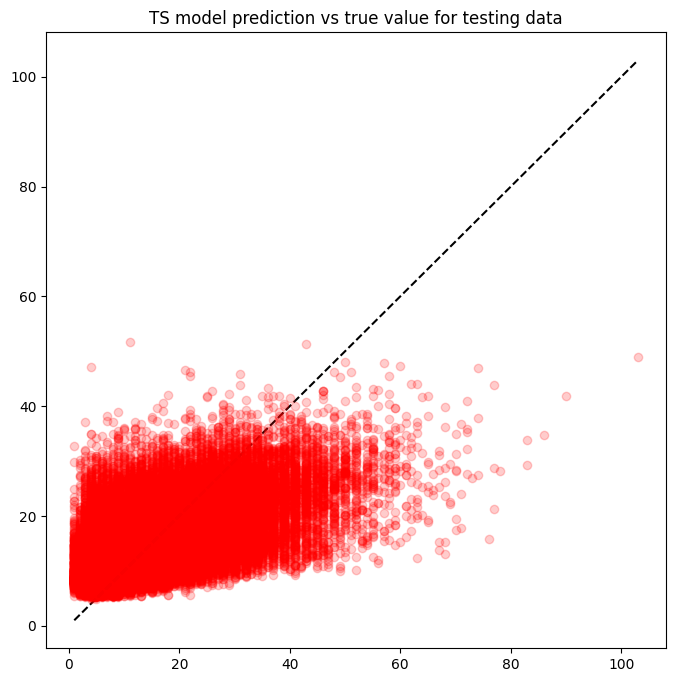

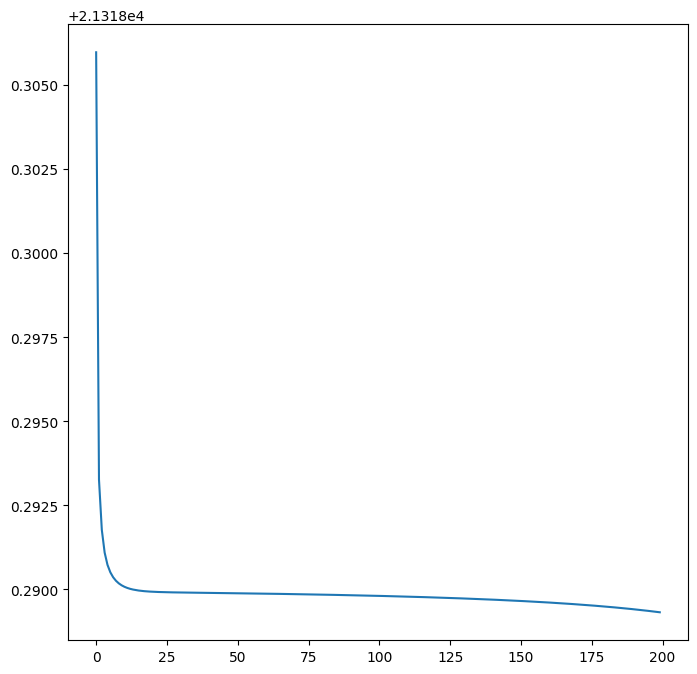

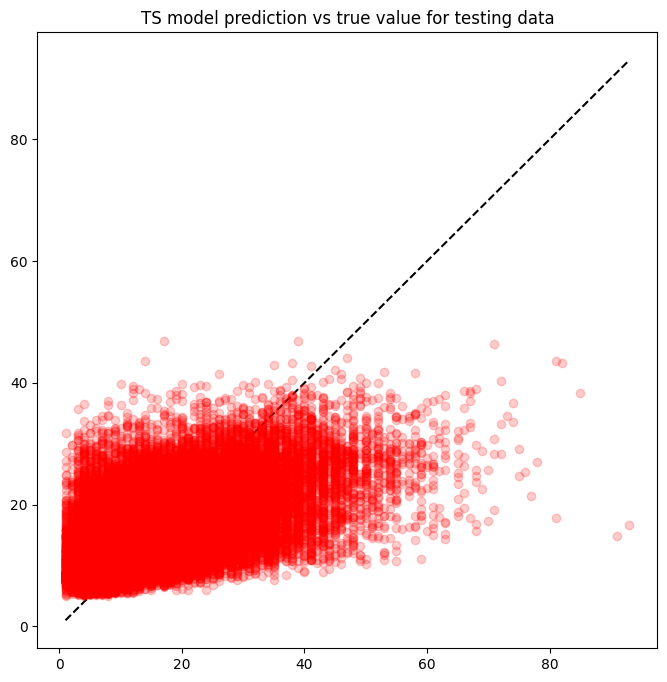

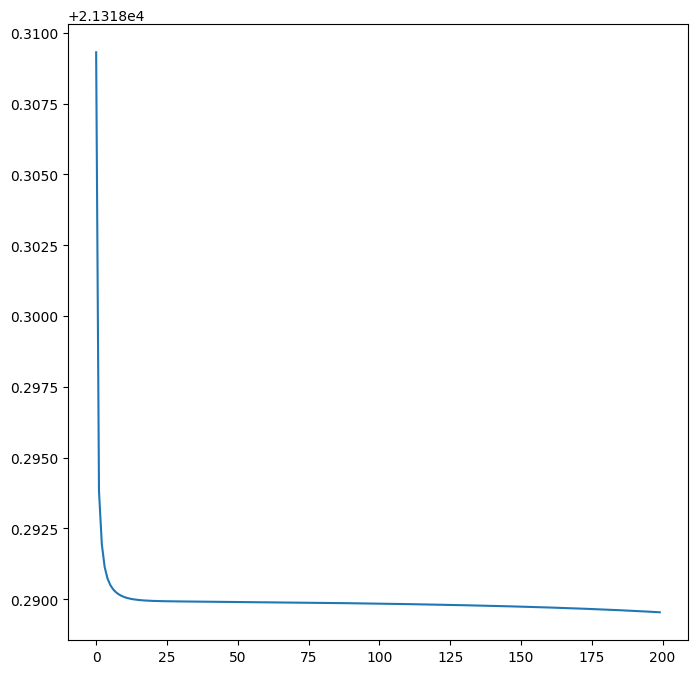

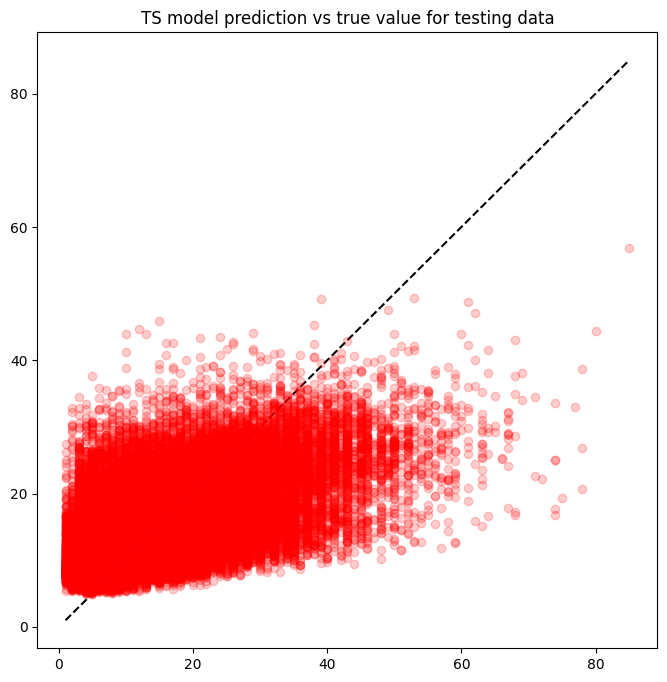

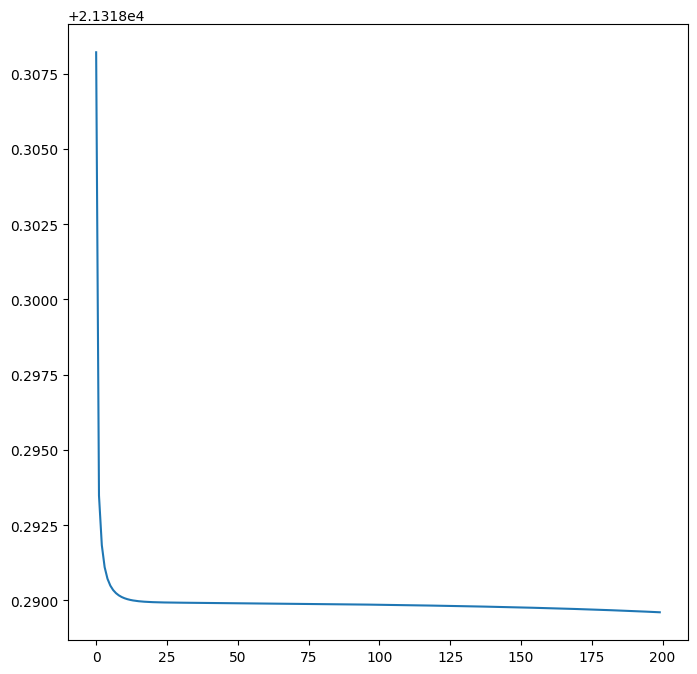

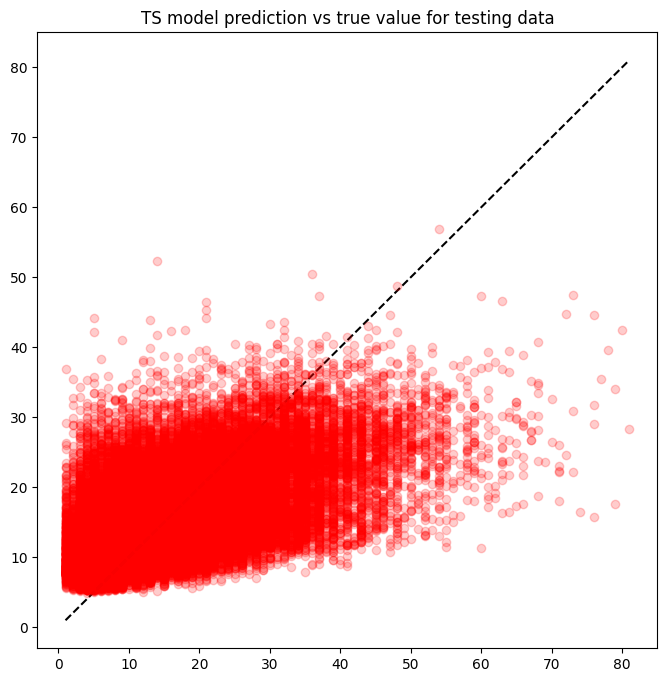

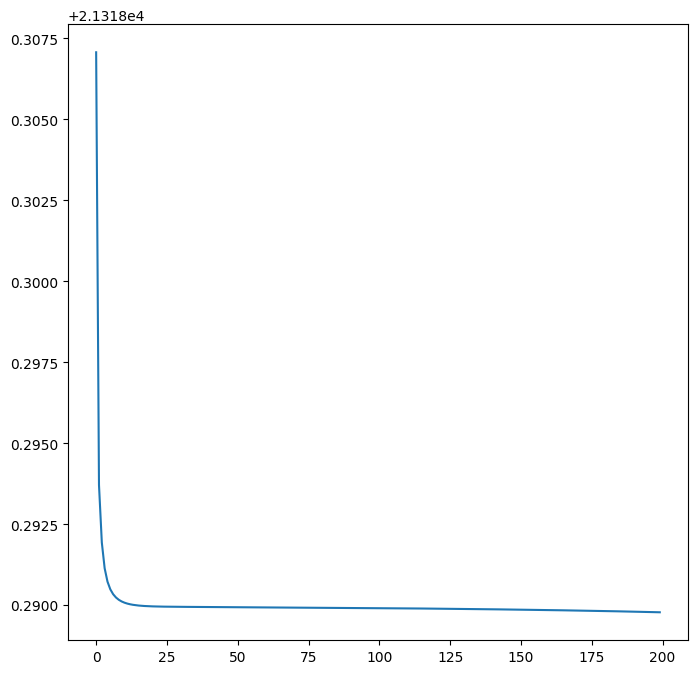

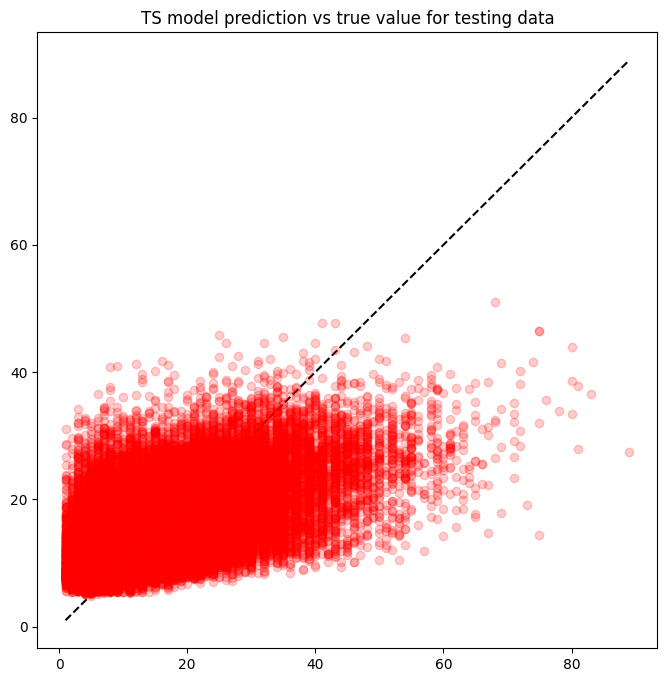

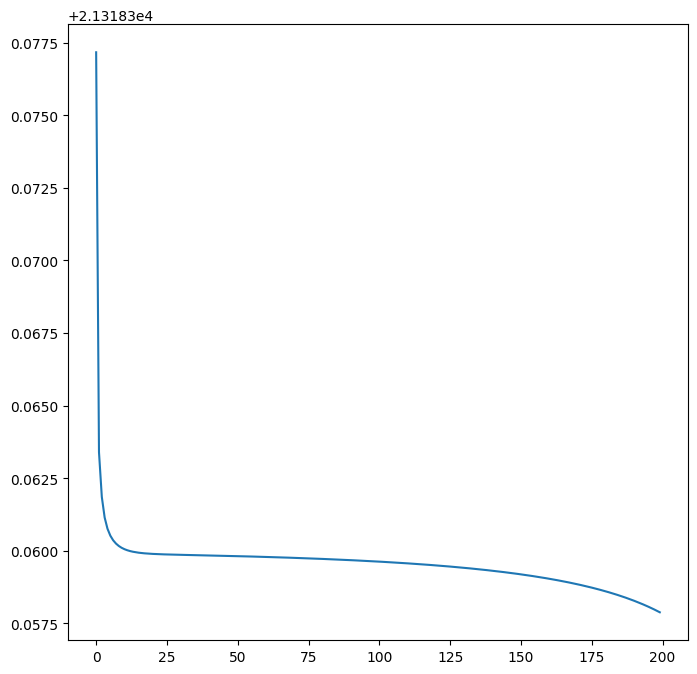

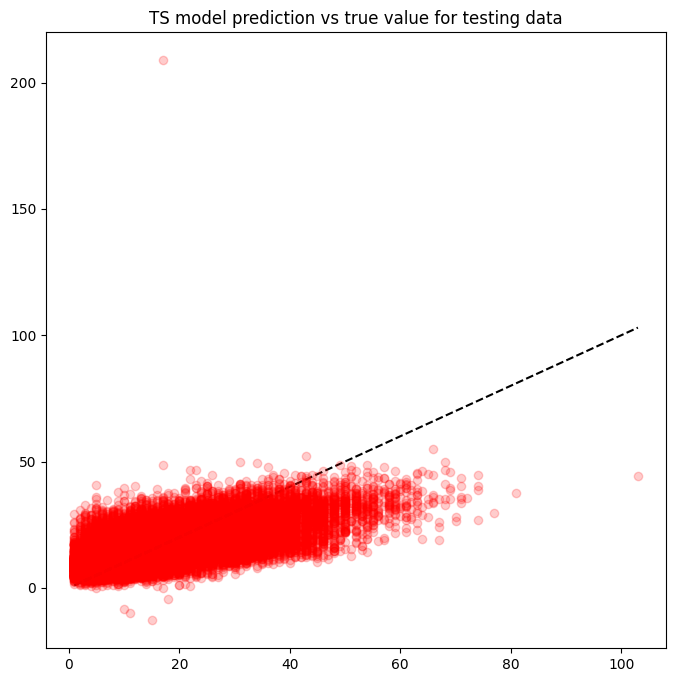

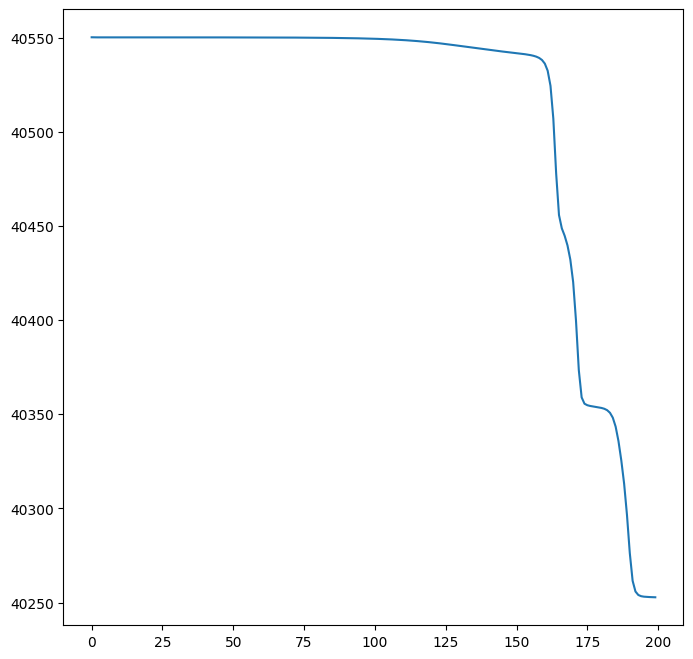

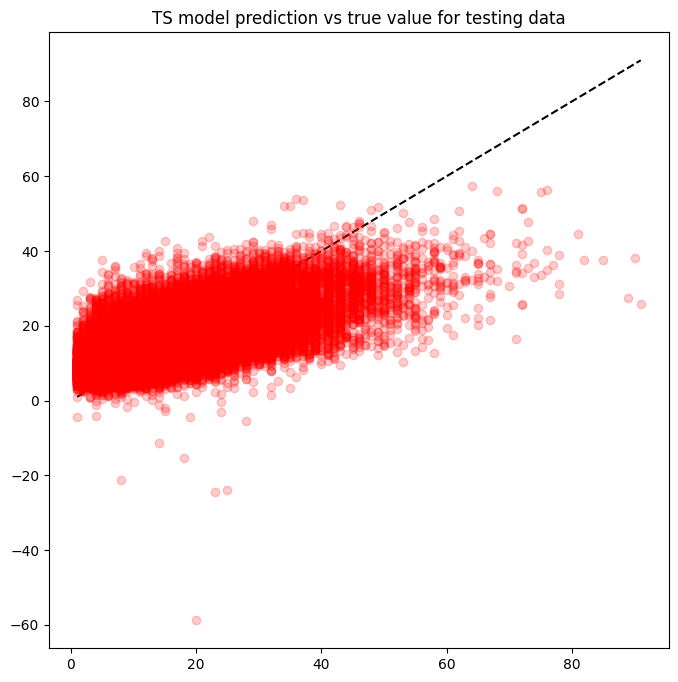

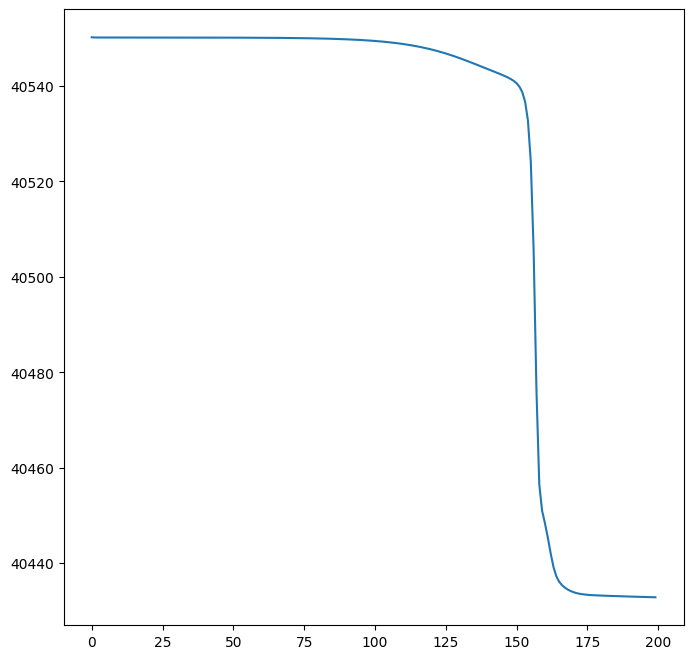

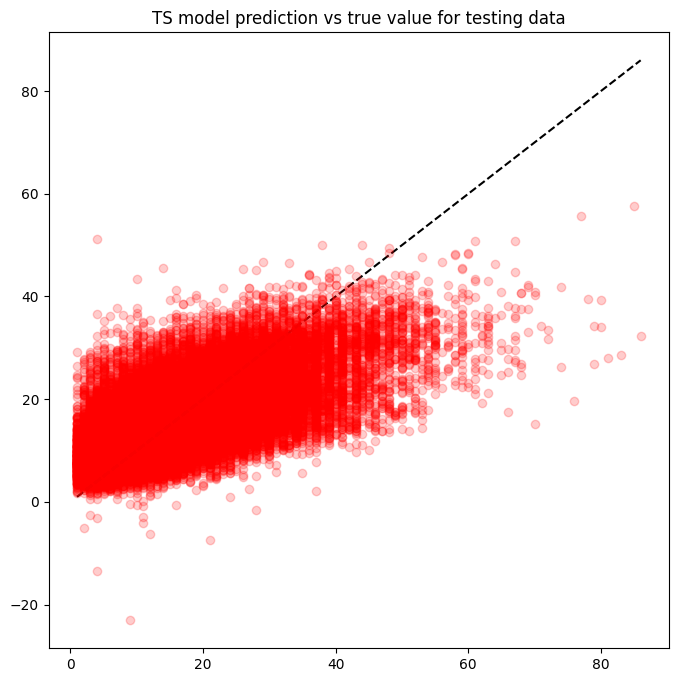

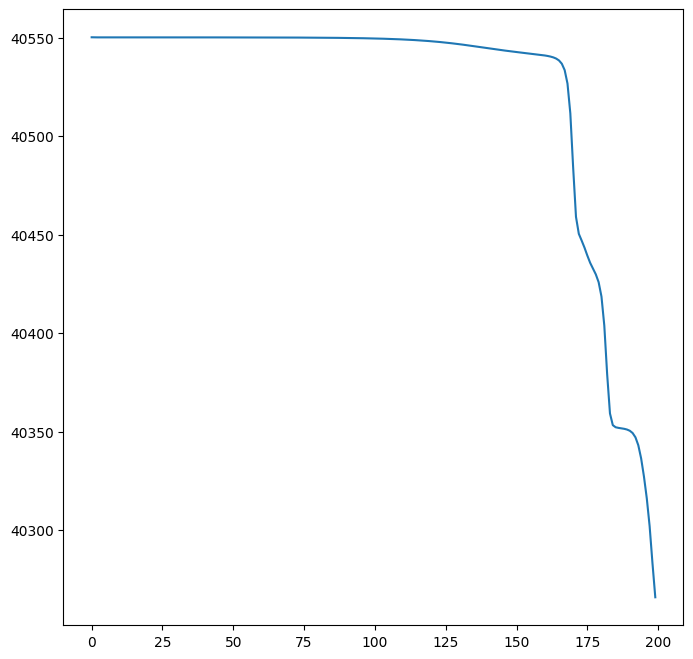

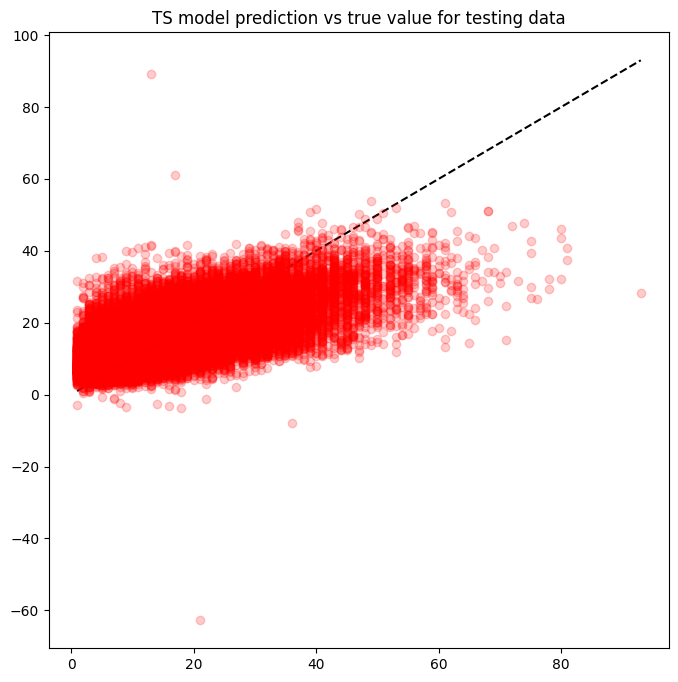

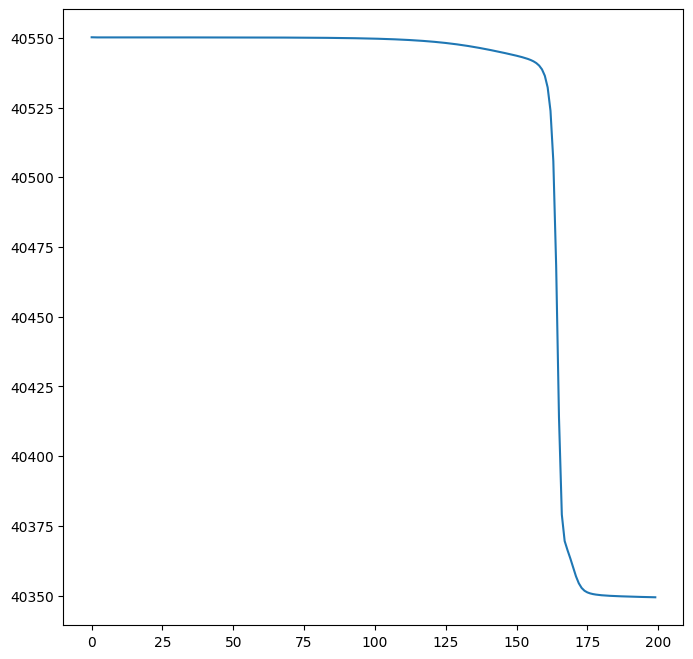

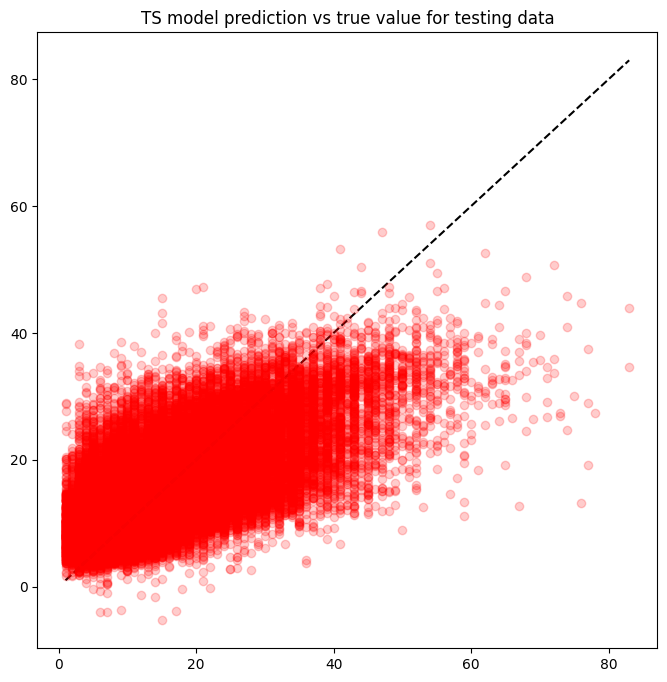

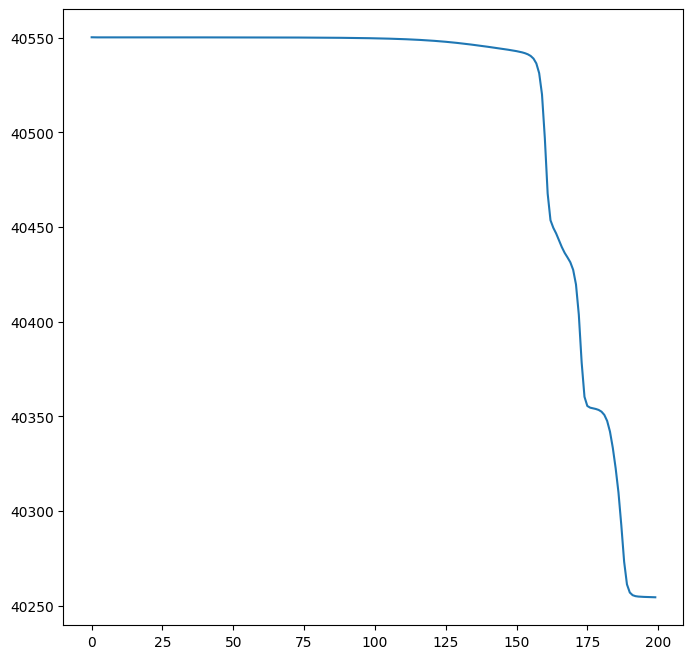

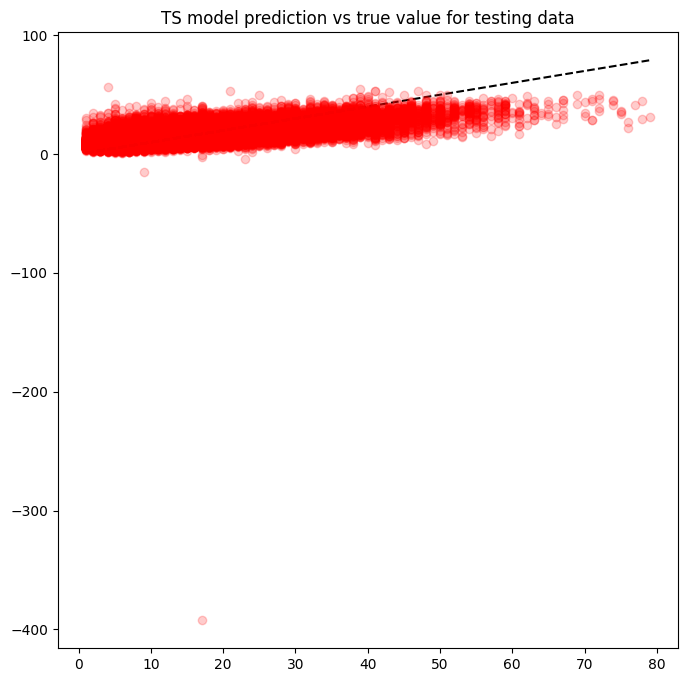

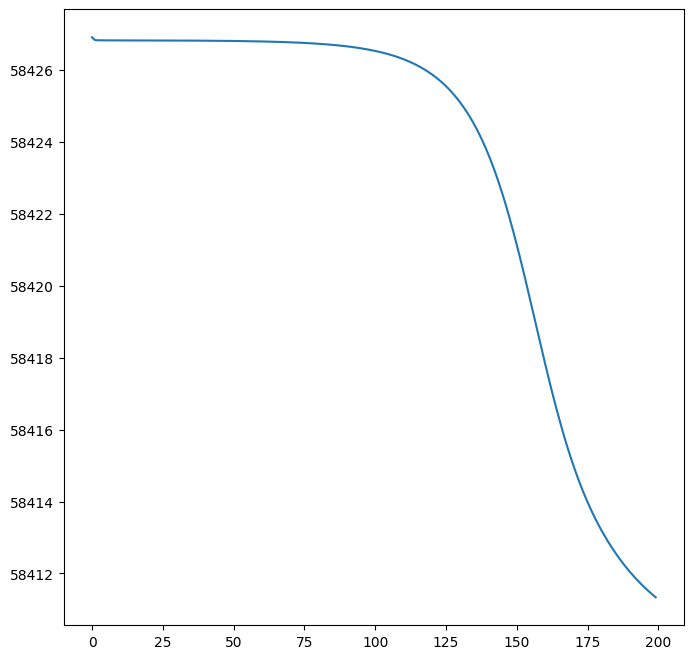

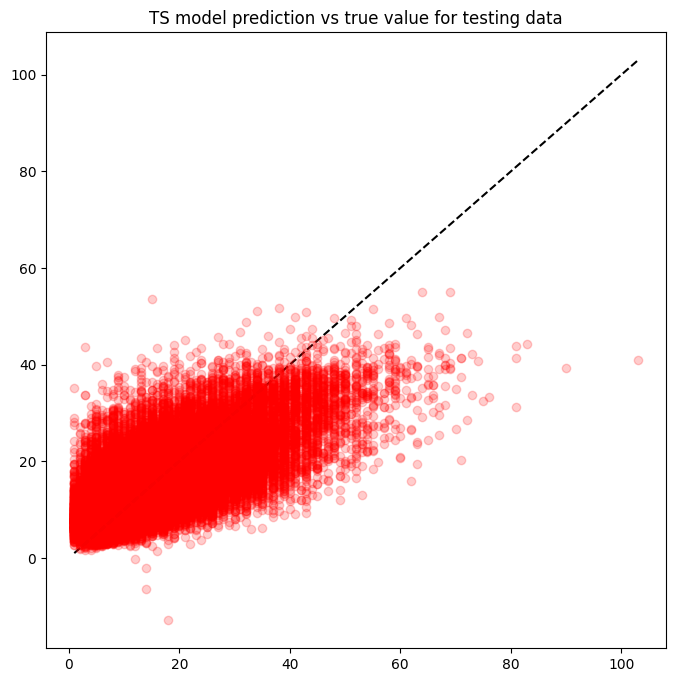

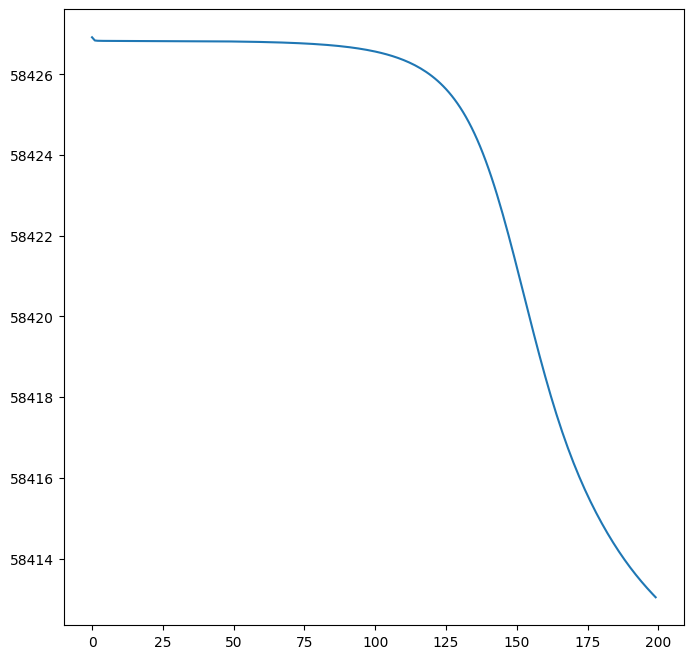

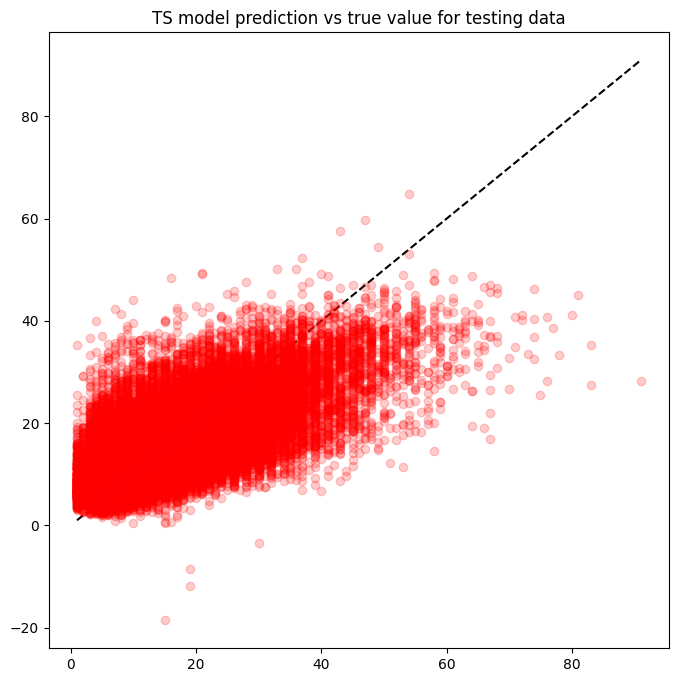

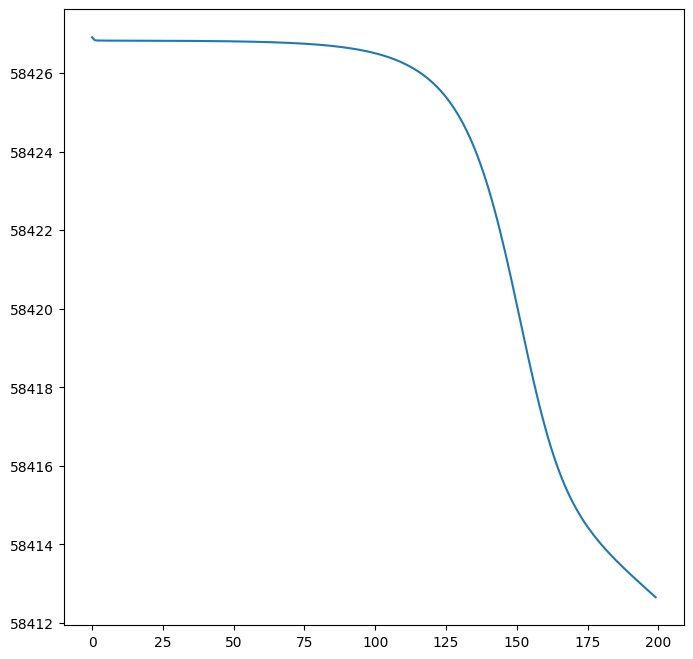

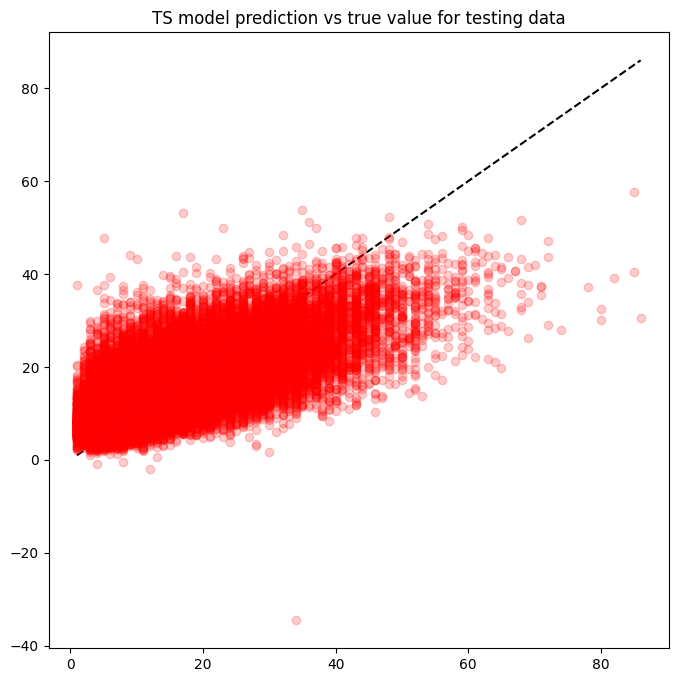

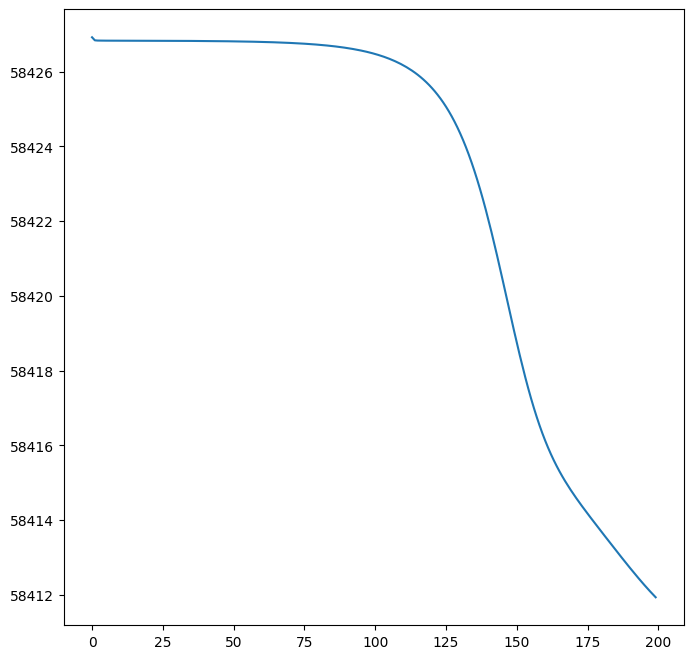

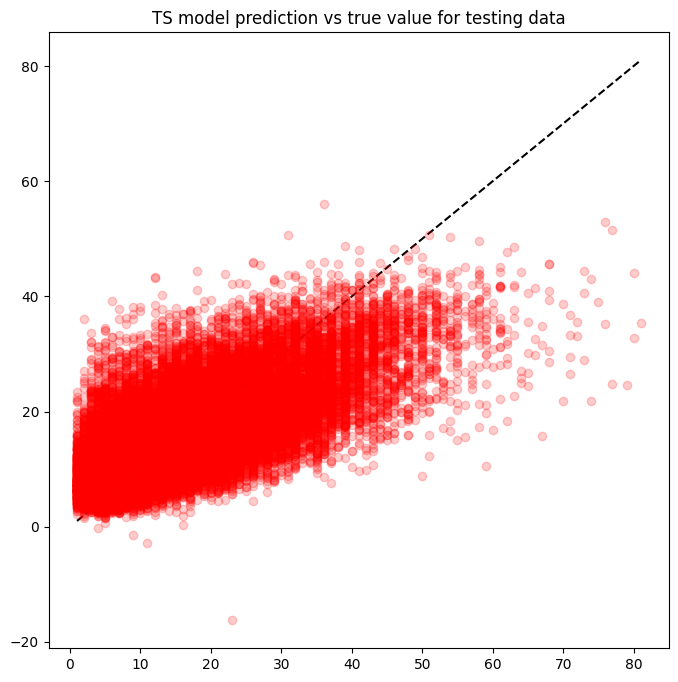

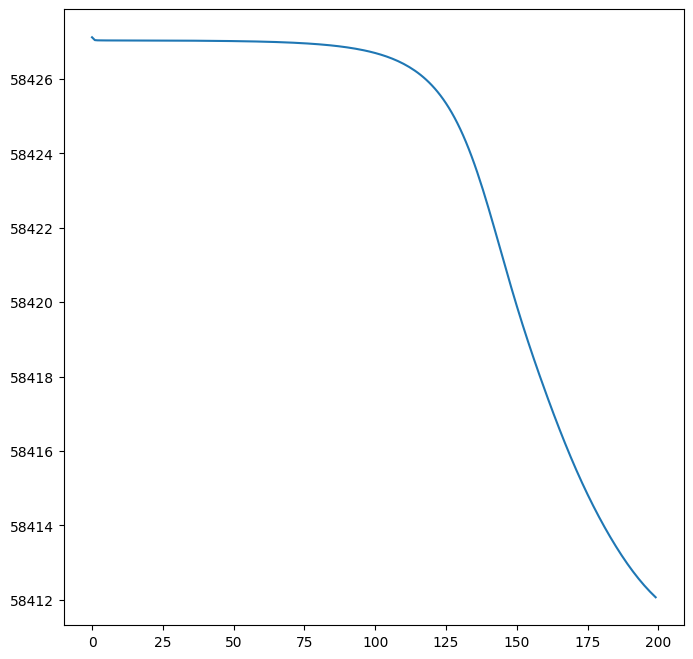

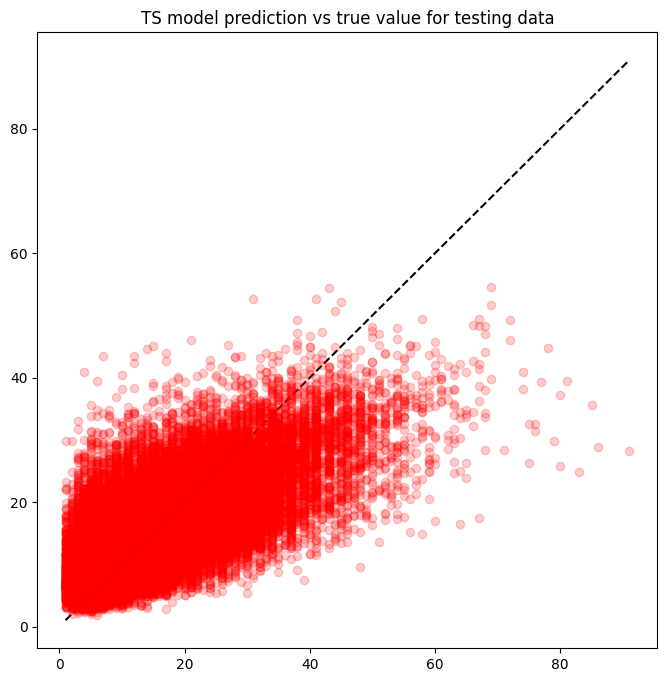

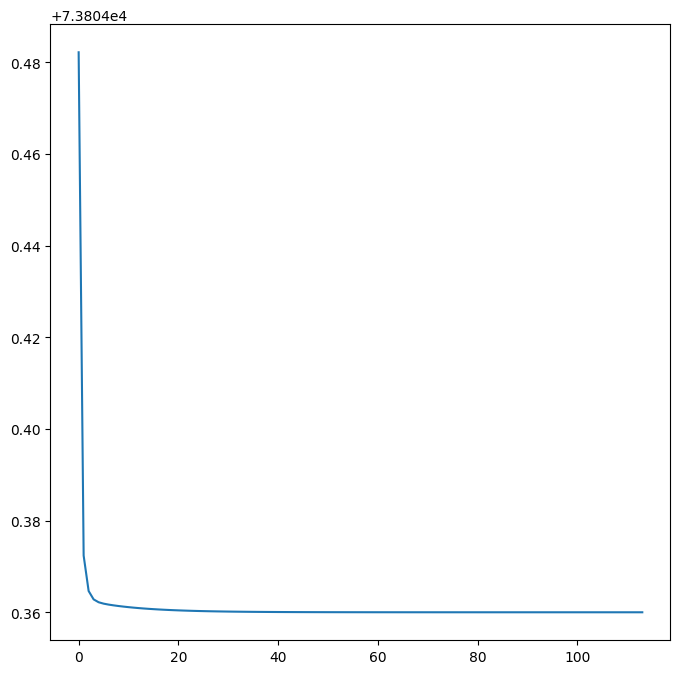

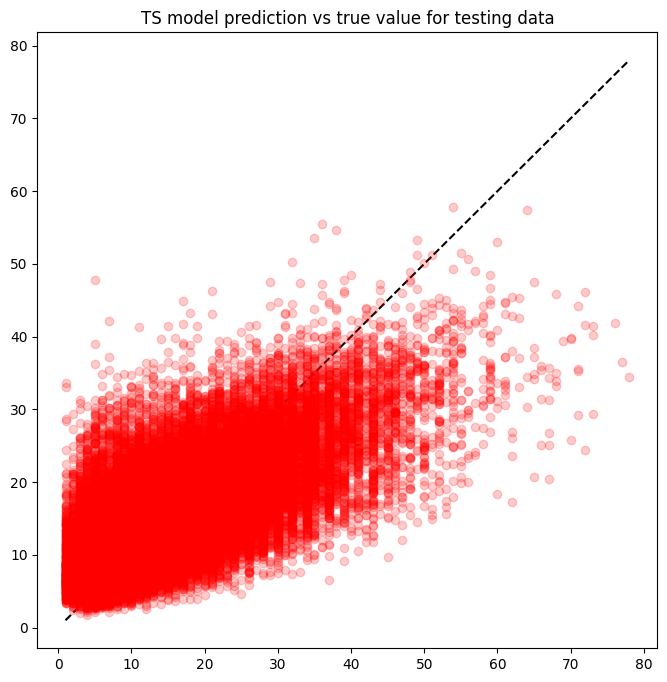

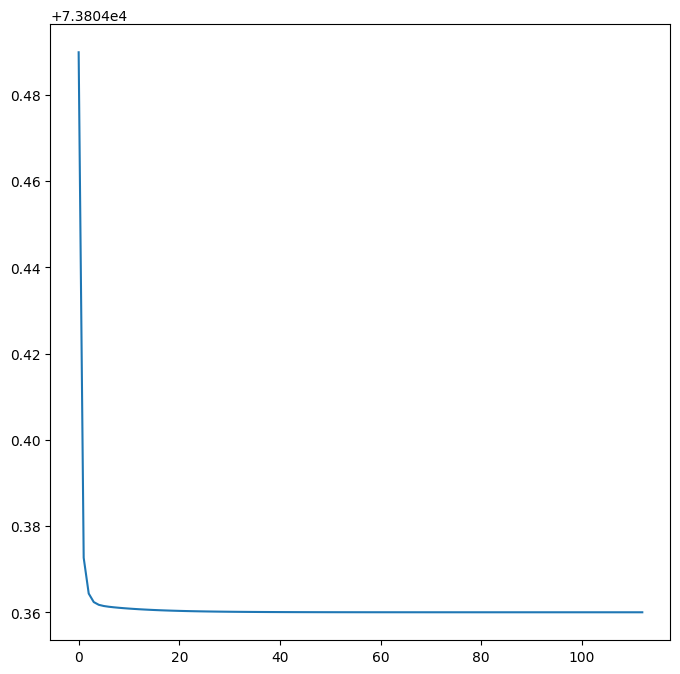

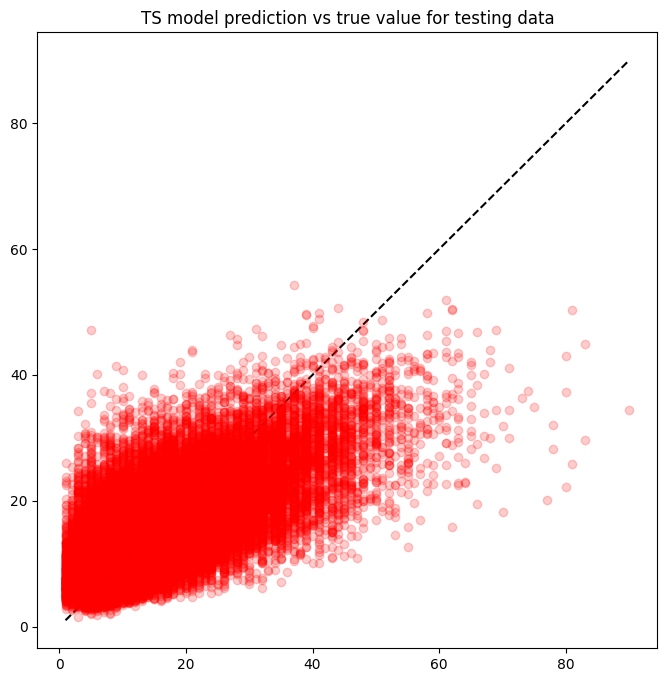

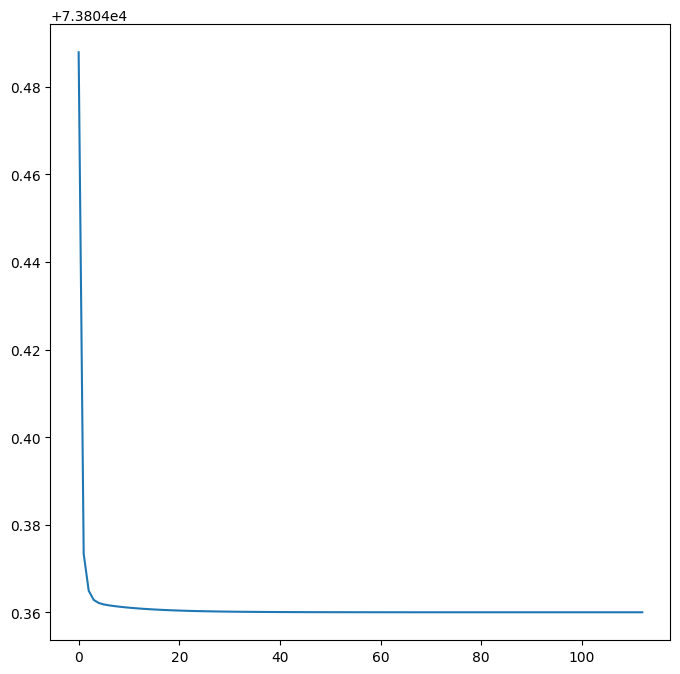

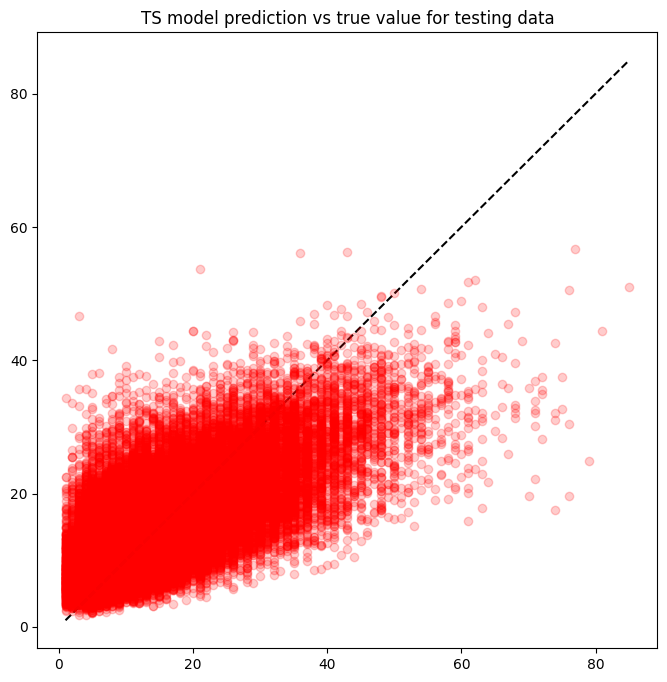

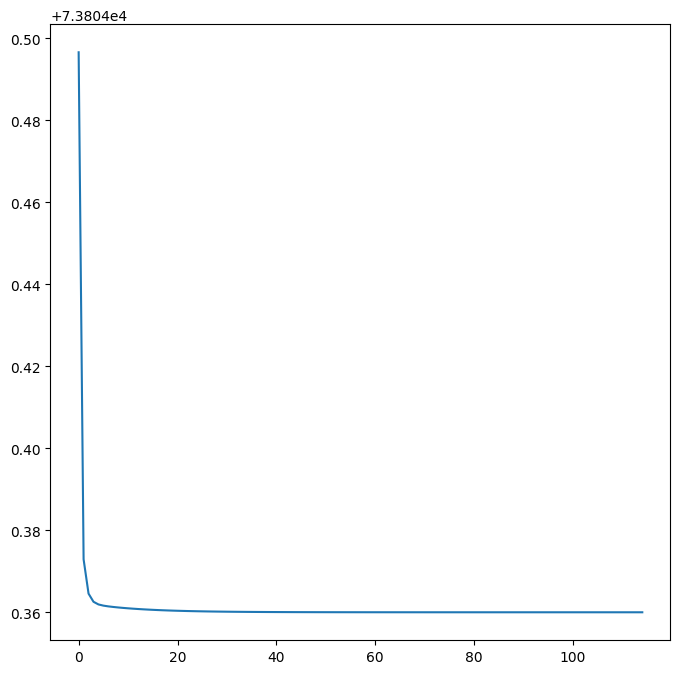

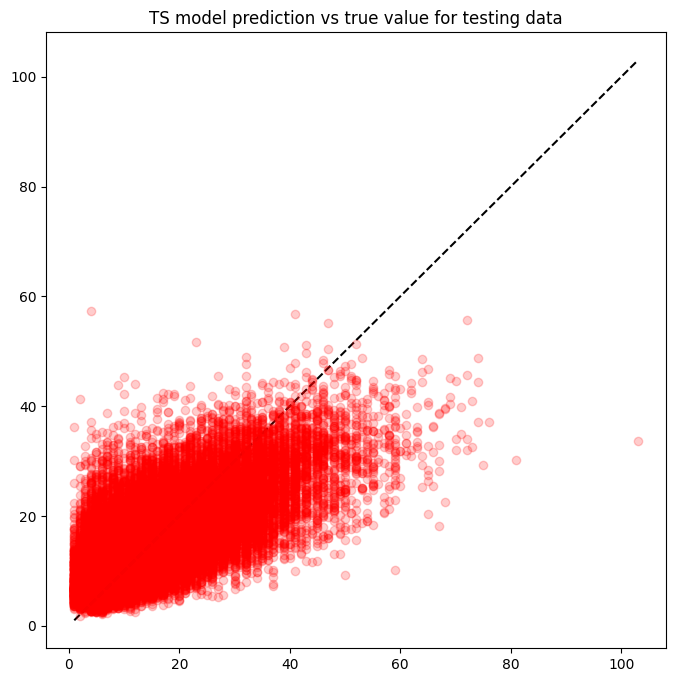

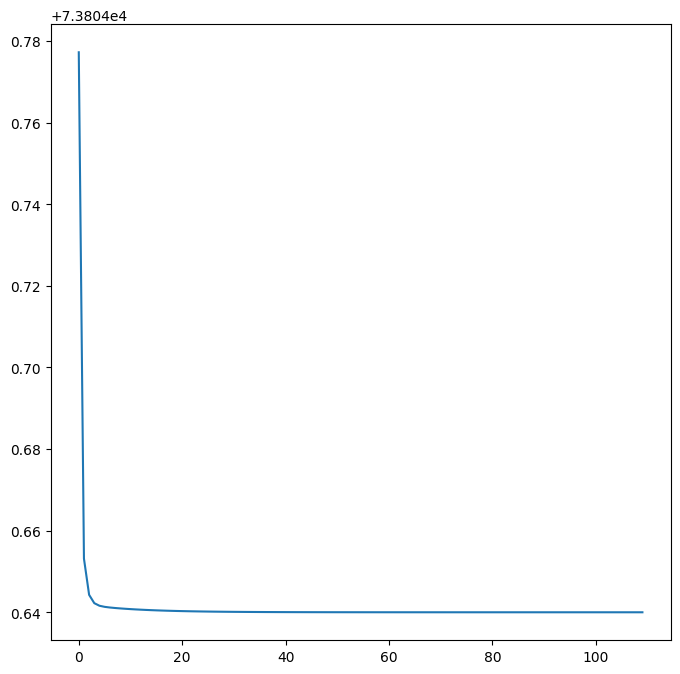

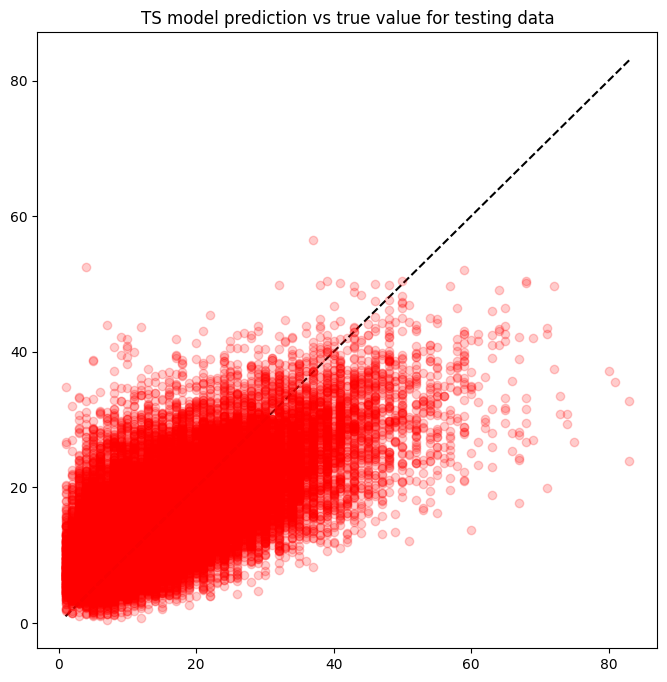

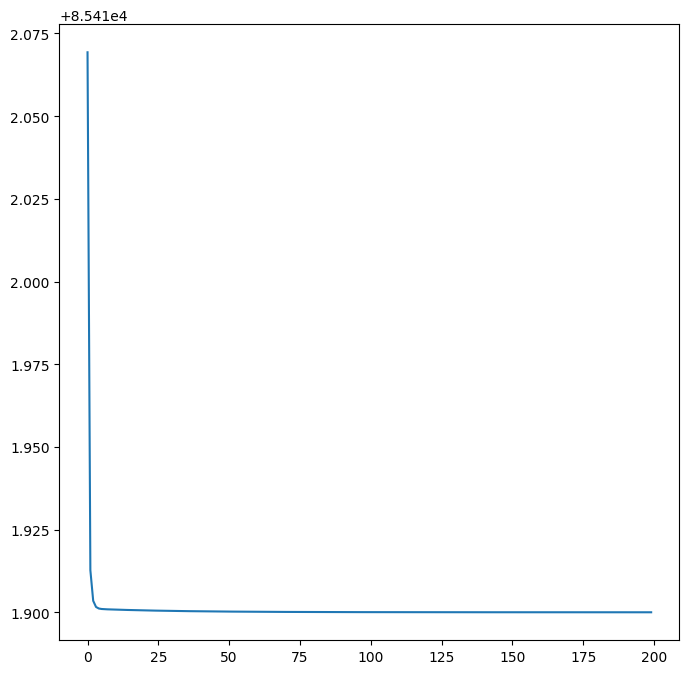

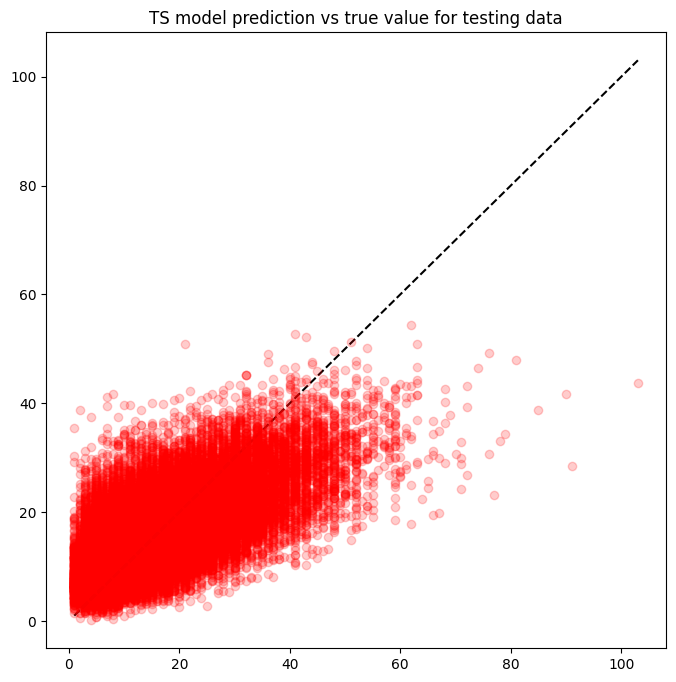

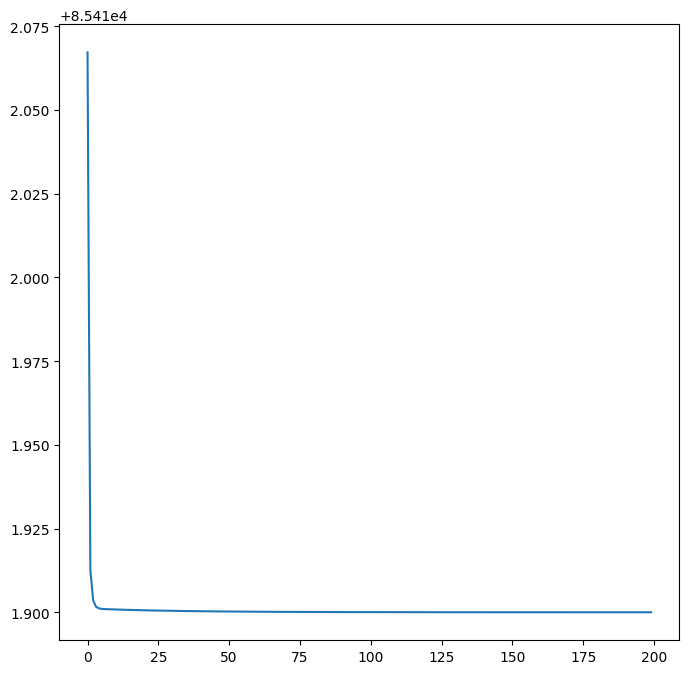

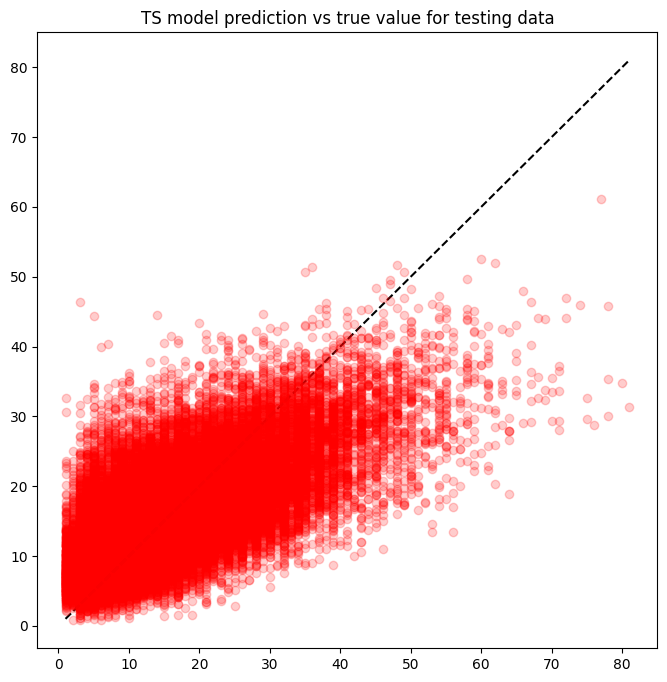

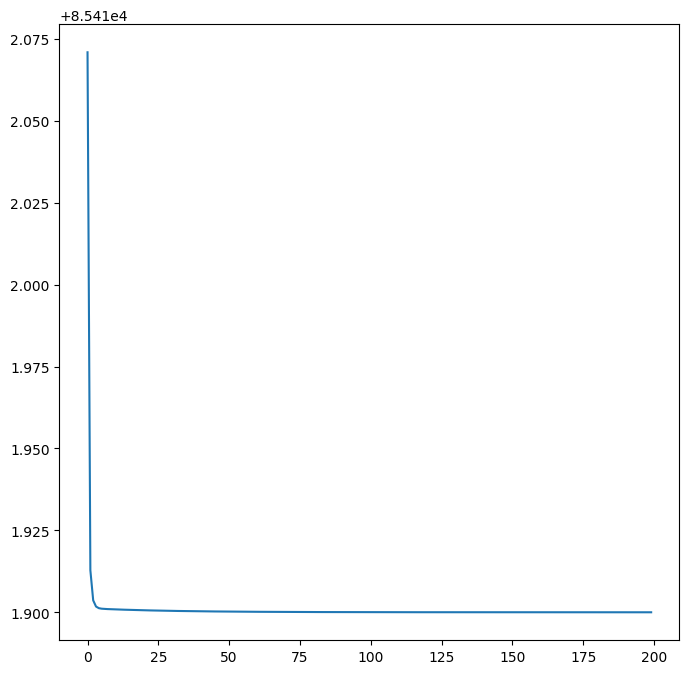

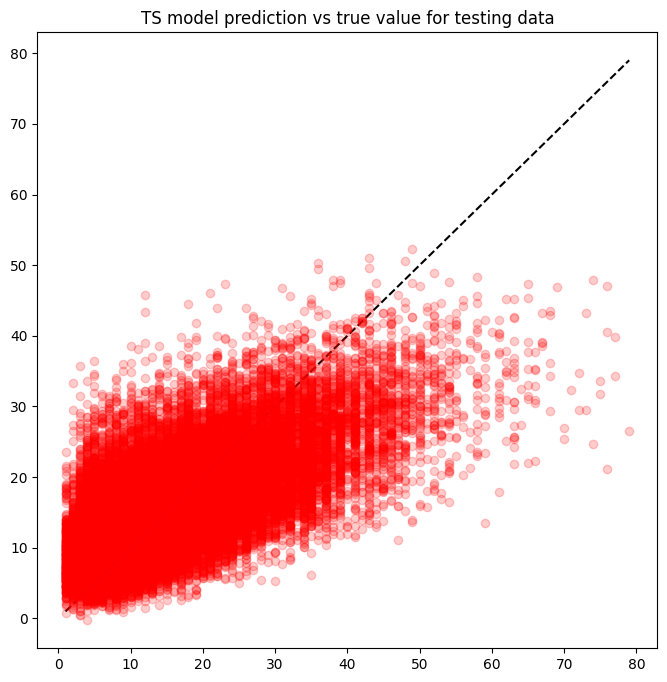

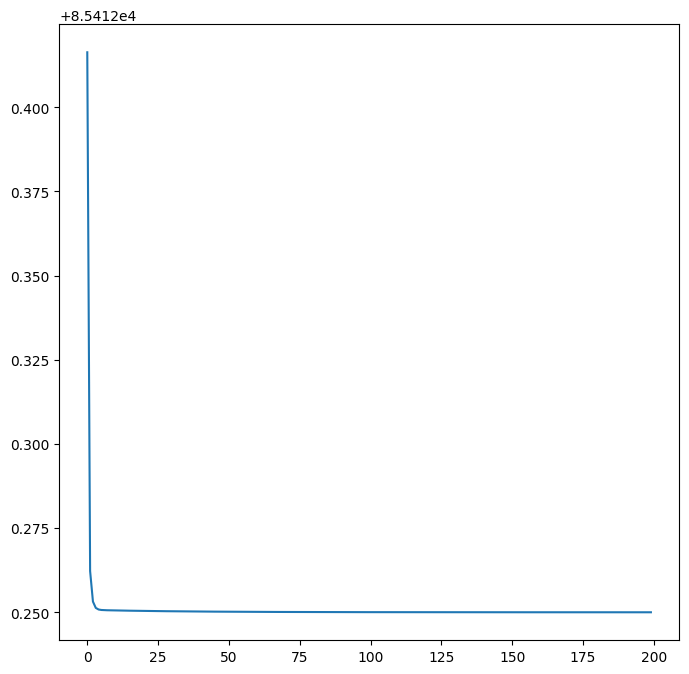

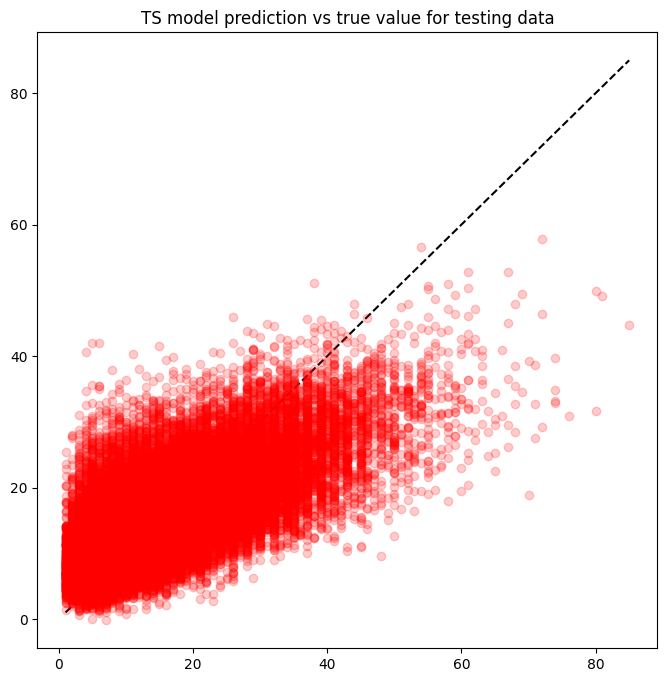

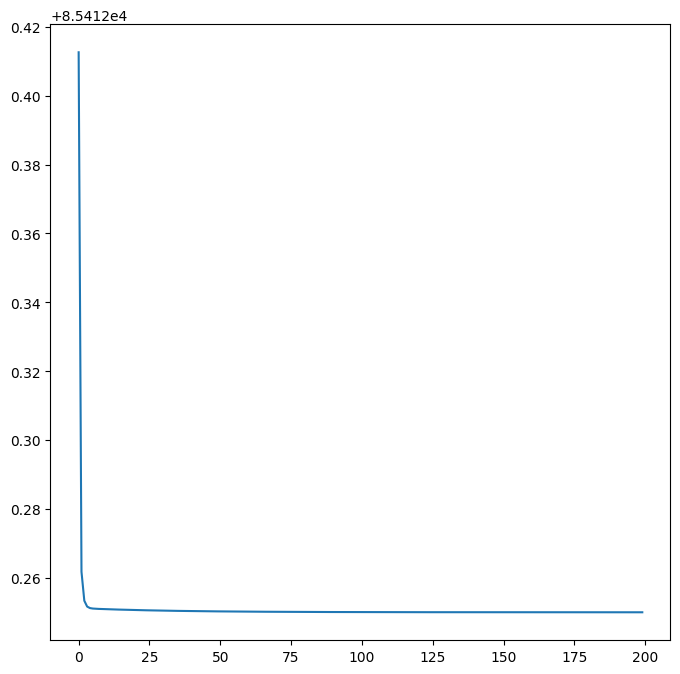

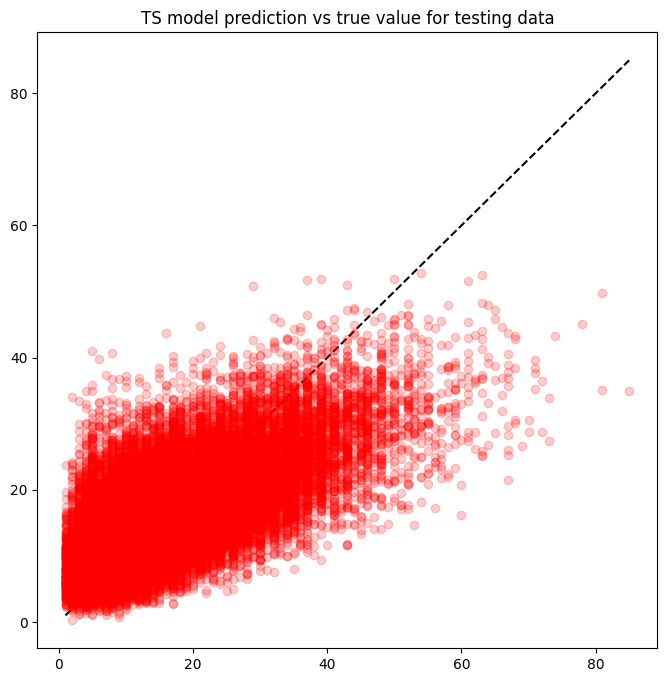

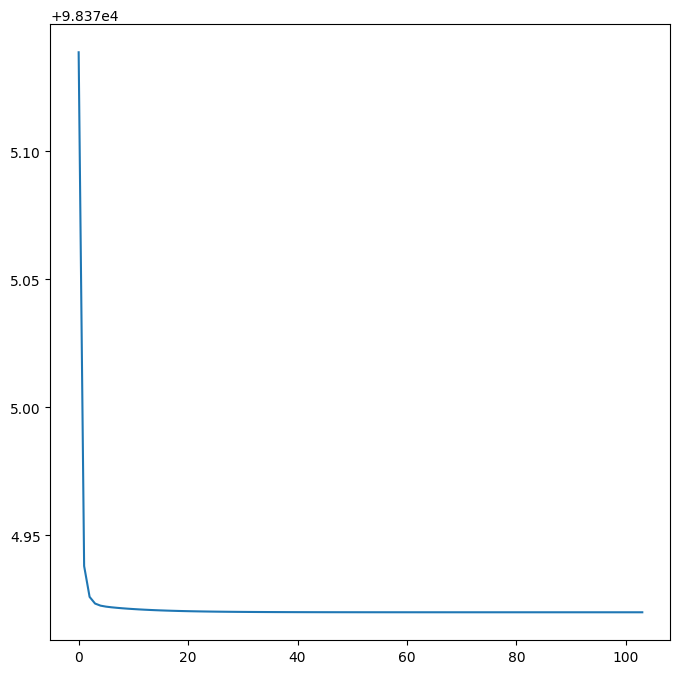

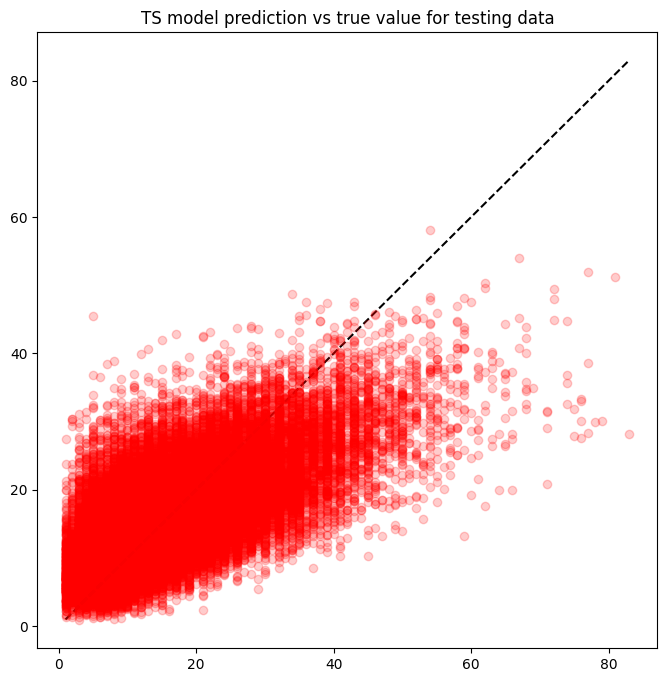

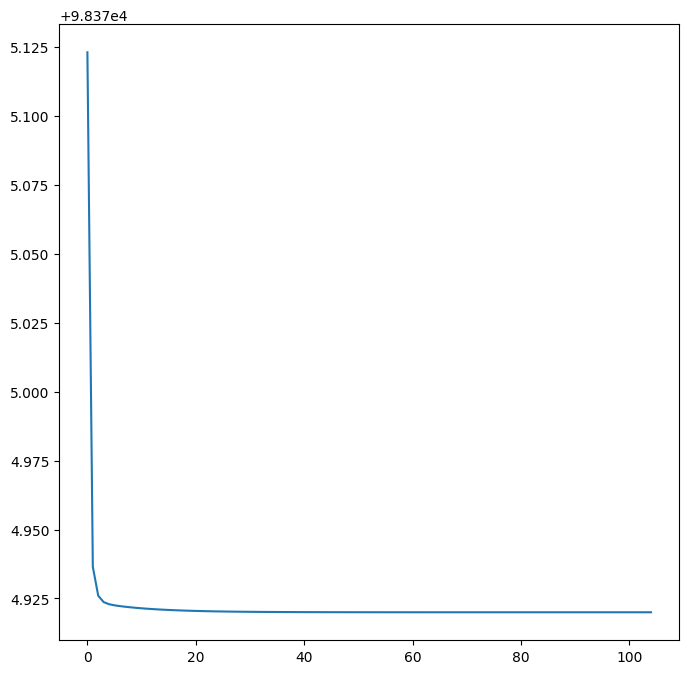

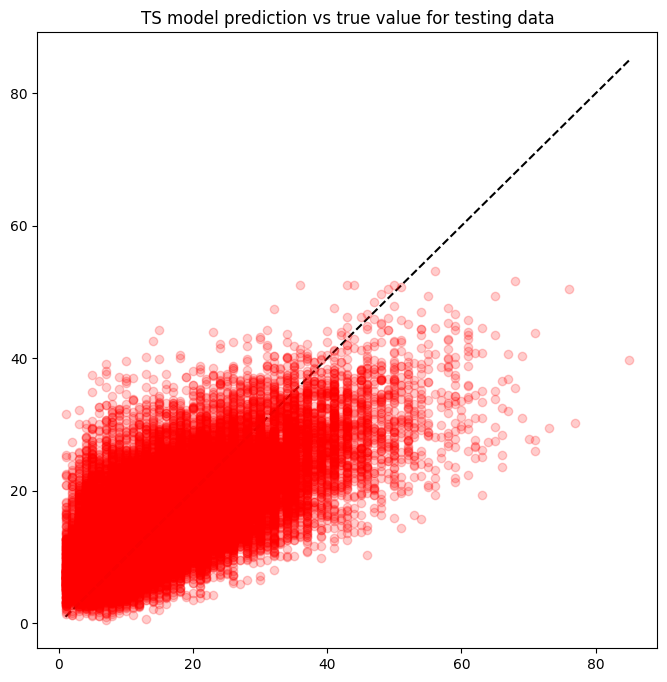

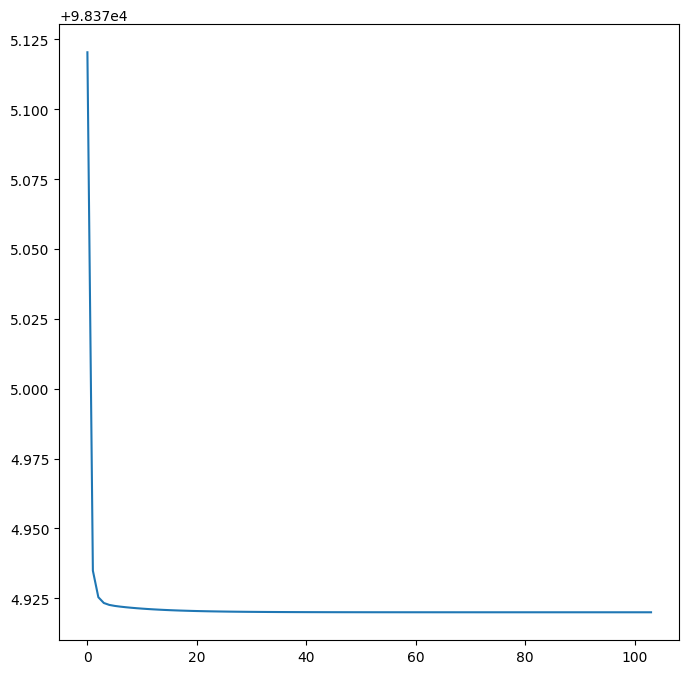

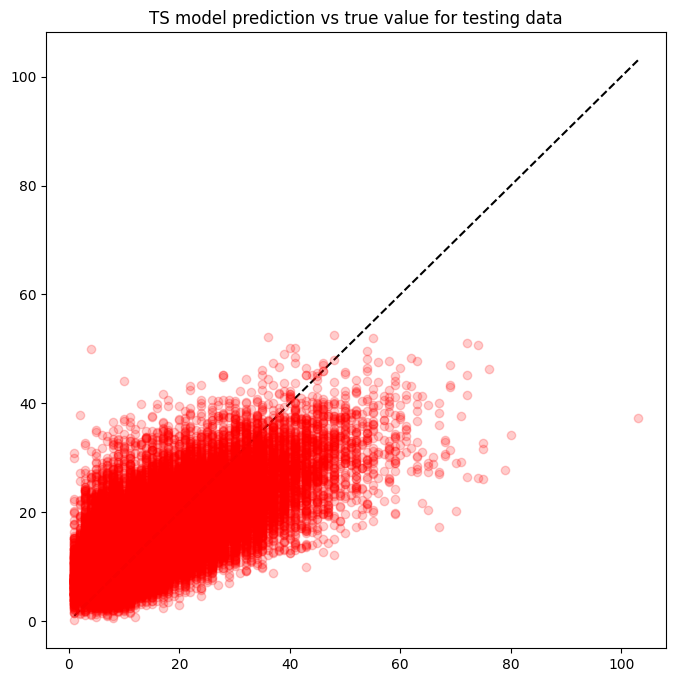

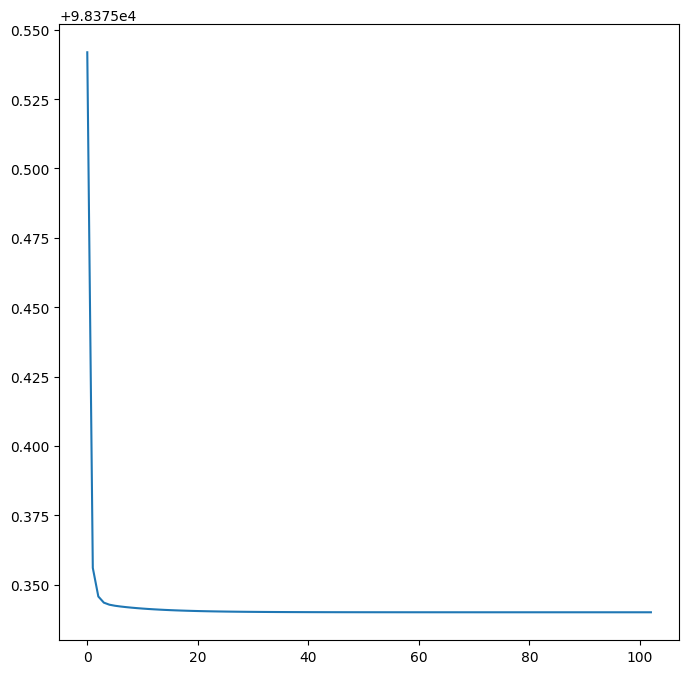

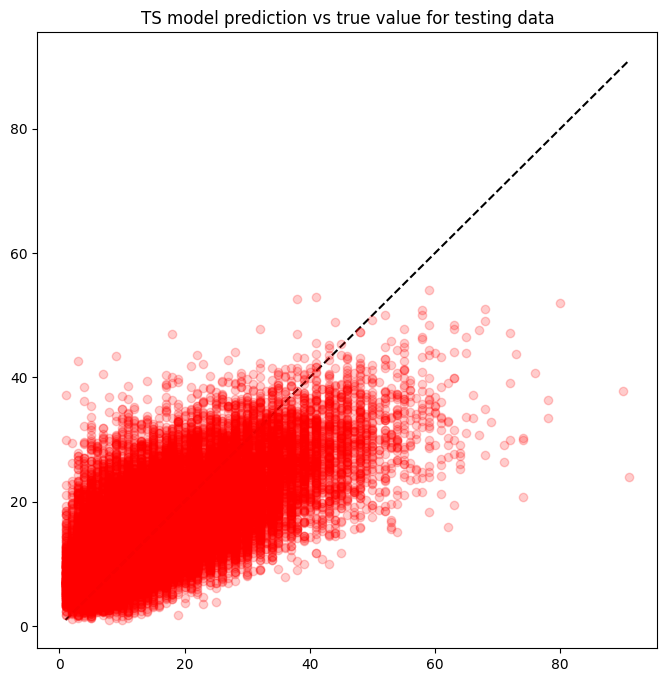

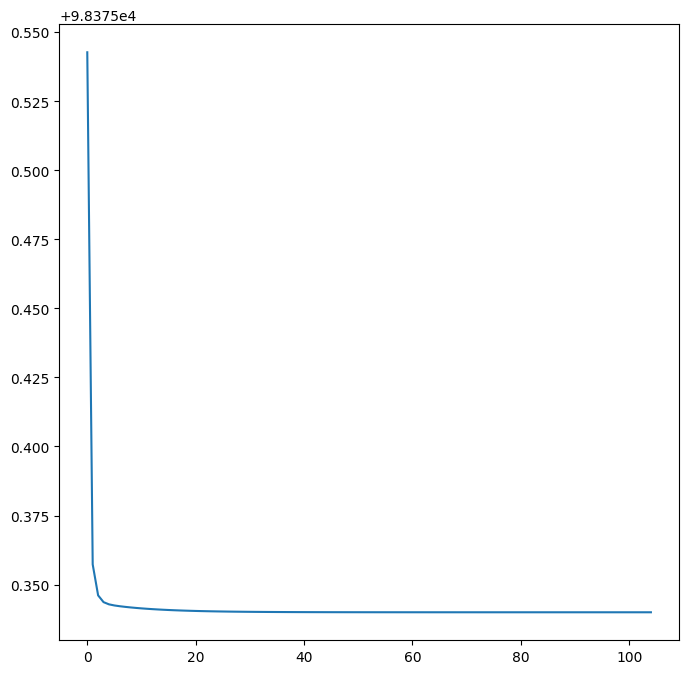

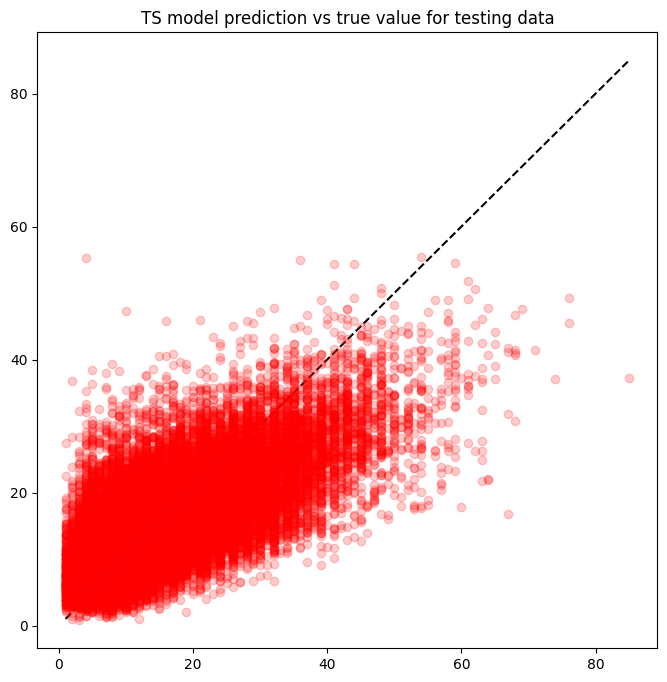

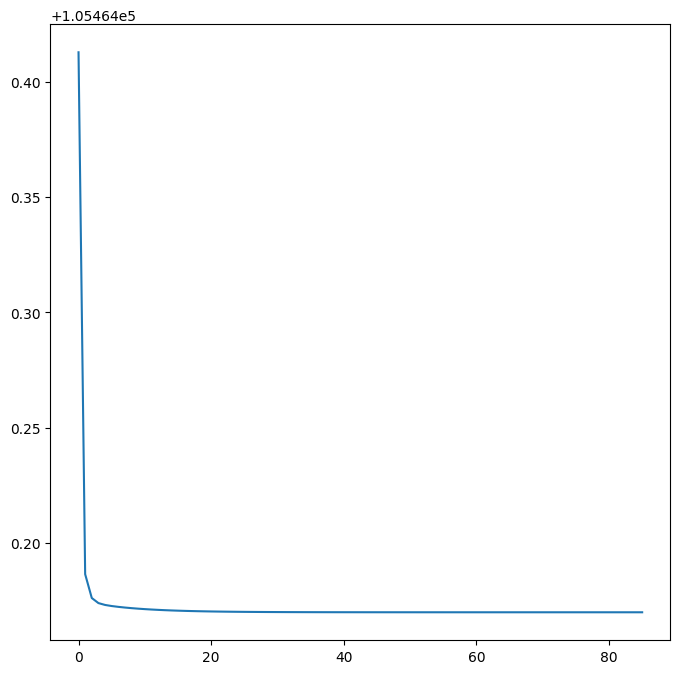

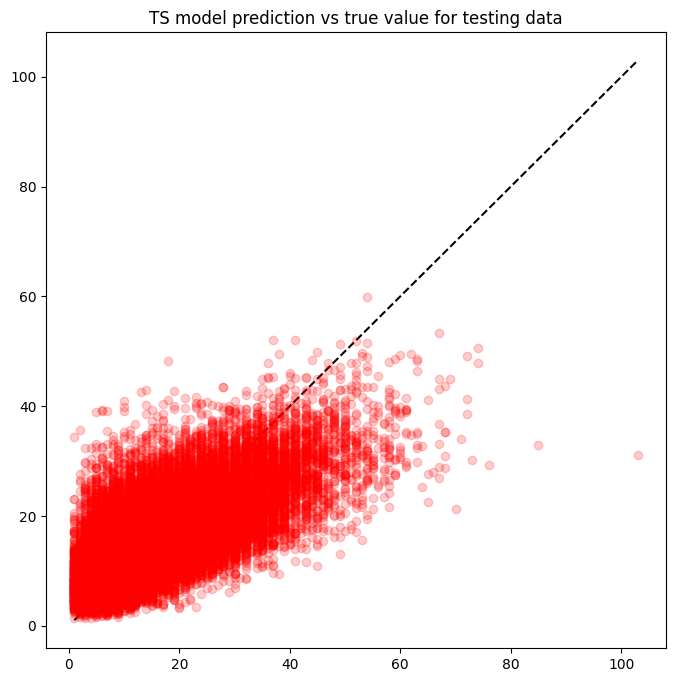

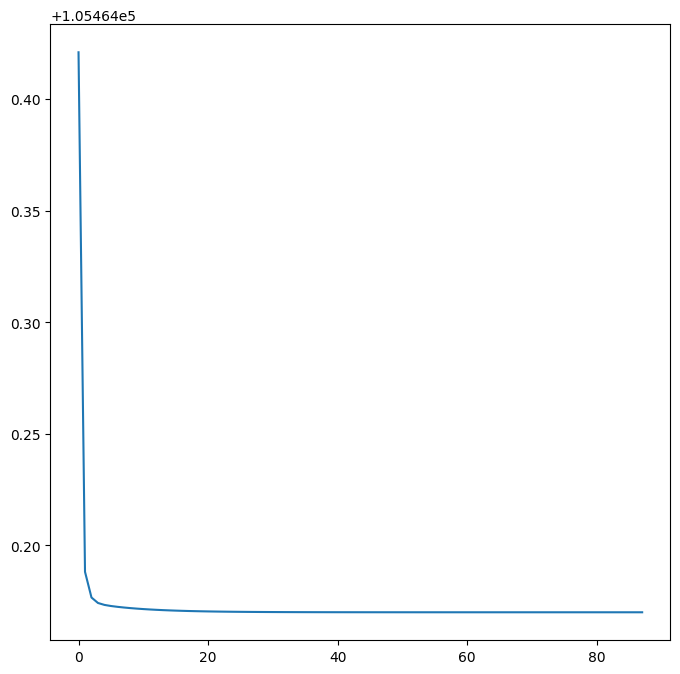

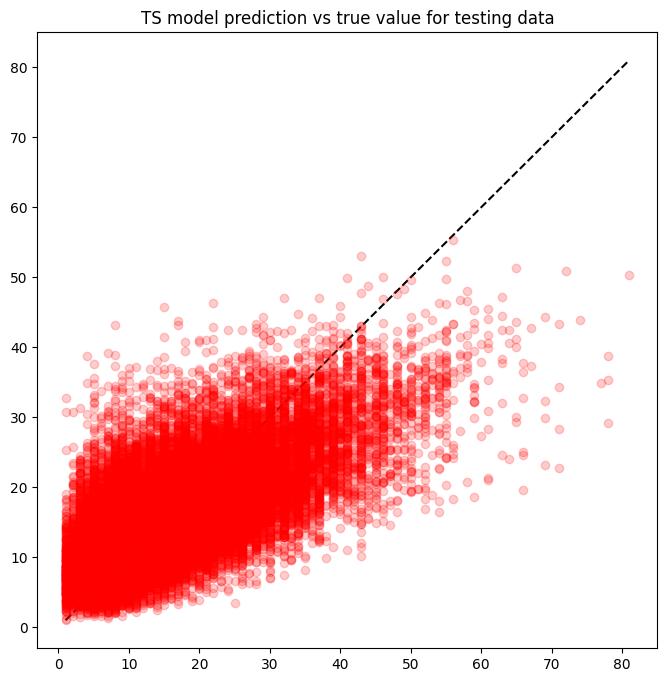

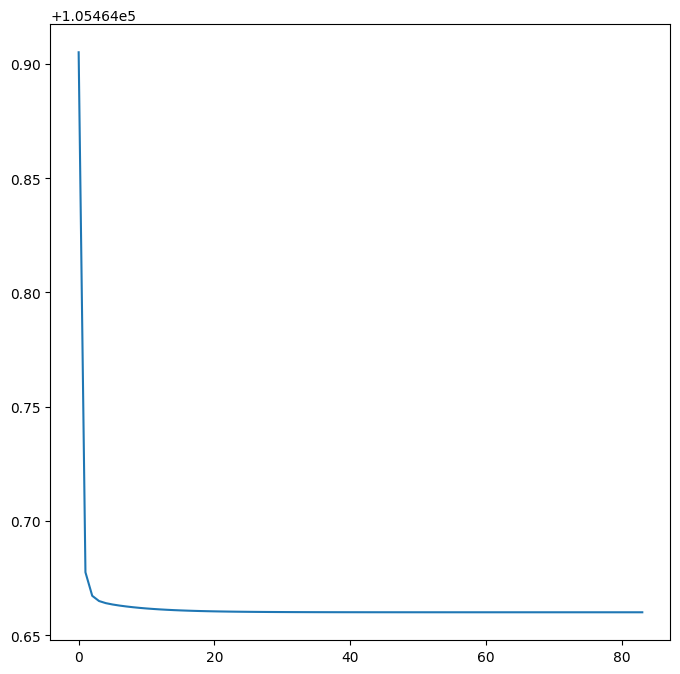

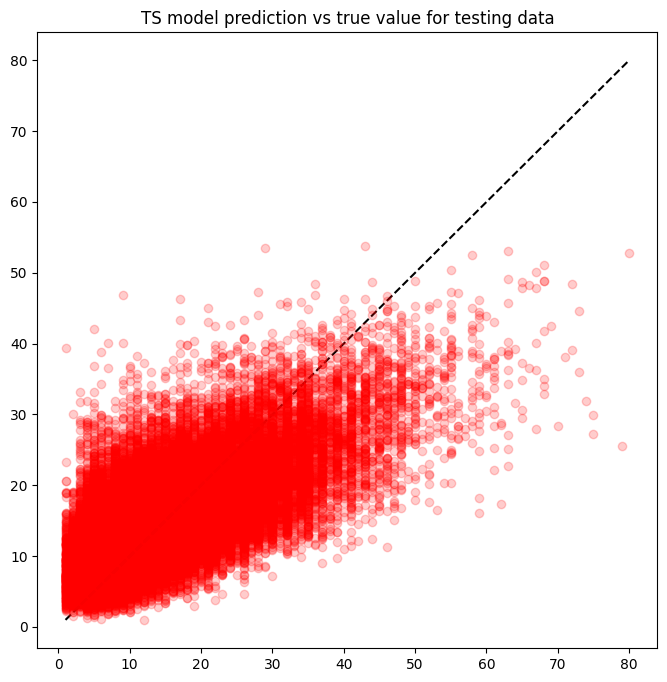

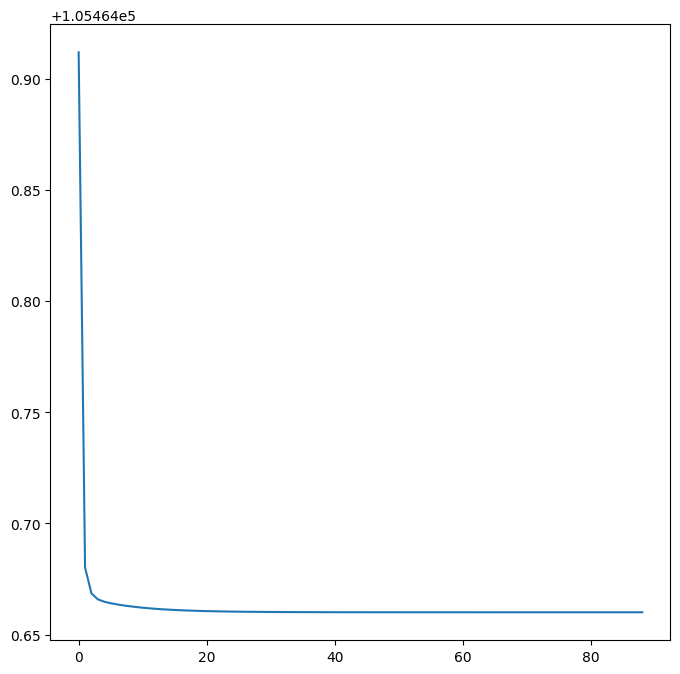

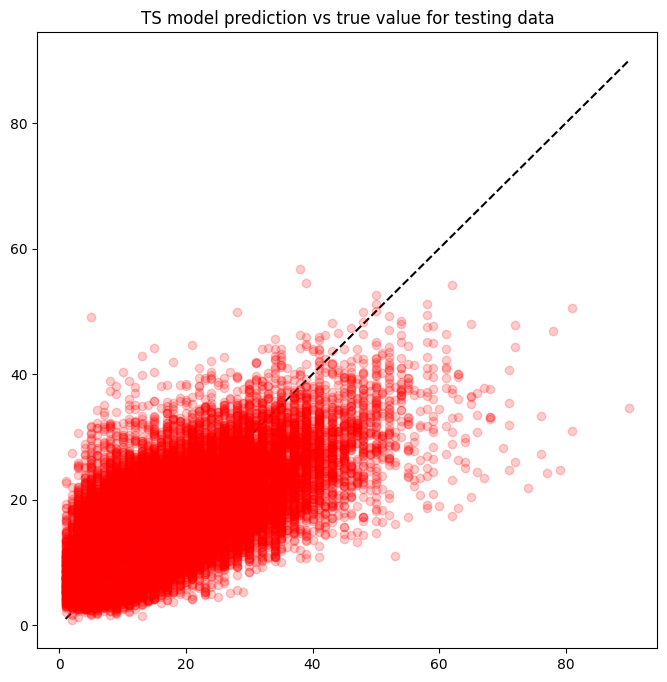

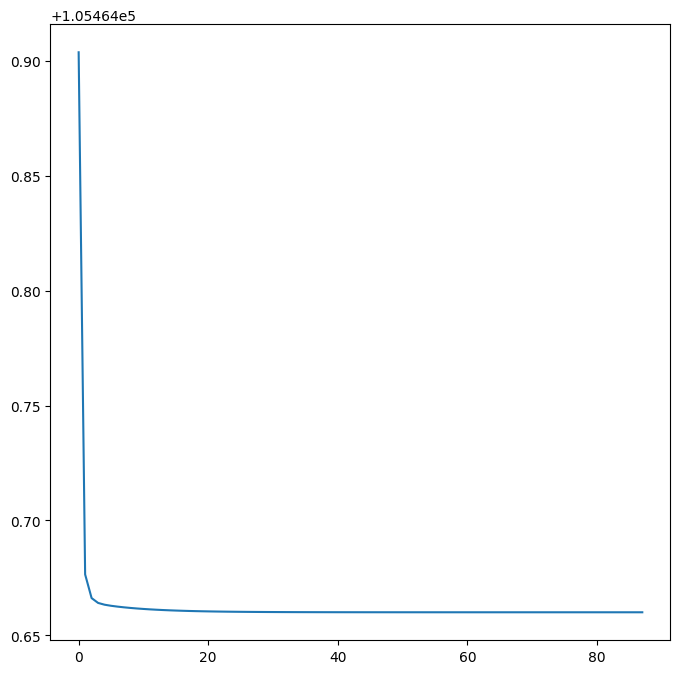

In [110]:
do_experiment(number_of_neighbour_stations, train_data)

exp
7.5962±0.0044
7.49±0.0044
6.8221±0.0034
exp
7.3263±0.0032
6.8824±0.0171
6.3035±0.0048
exp
7.0778±0.0062
6.5905±0.008
6.0517±0.0075
exp
6.8874±0.0073
6.6901±0.0065
6.0016±0.01
exp
6.9439±0.0057
6.7833±0.0058
5.999±0.0132
exp
6.7848±0.0063
6.7375±0.0064
5.9326±0.0048
exp
6.7202±0.004
6.6459±0.0043
5.8963±0.0073


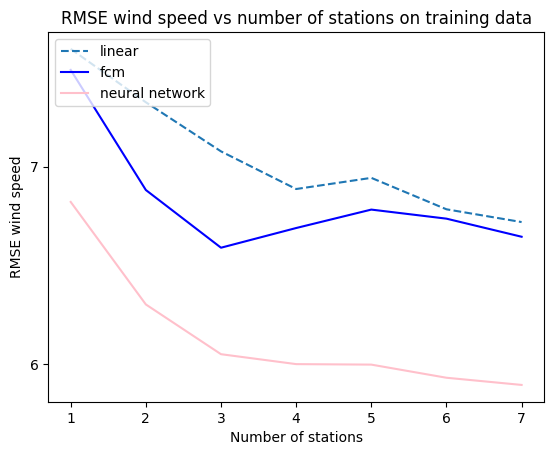

In [129]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = [1,2,3,4,5,6,7]#number_of_neighbour_stations
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
7.5963±0.0176
7.4908±0.0181
6.8069±0.0296
exp
7.3267±0.0127
6.8991±0.0226
6.2877±0.0143
exp
7.0783±0.0249
6.6333±0.0619
6.039±0.024
exp
6.8881±0.0292
6.6915±0.026
5.9944±0.0263
exp
6.9448±0.0228
6.7852±0.0227
5.9994±0.017
exp
6.7861±0.0252
6.74±0.0259
5.9388±0.0291
exp
6.7219±0.0162
6.6489±0.0179
5.9011±0.0116


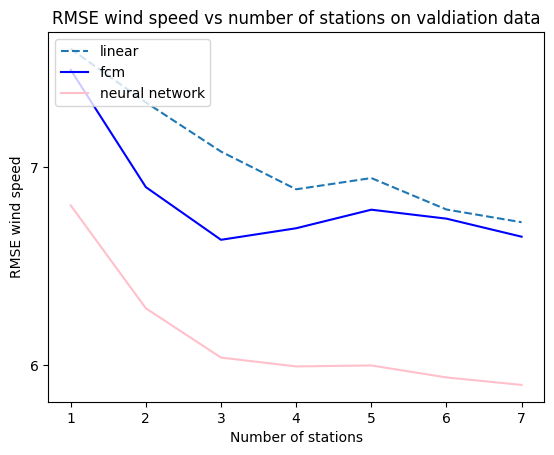

In [155]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = [1,2,3,4,5,6,7] #number_of_neighbour_stations
#x_axis = [1,2,3,4,5,6,7,8,9,10]
for exp in validation_results:
     li_train_plot.append(np.mean([d['linear_val'] for d in exp if 'linear_val' in d]))
     fcm_train_plot.append(np.mean([d['fcm_val'] for d in exp if 'fcm_val' in d]))
     nn_train_plot.append(np.mean([d['nn_val'] for d in exp if 'nn_val' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on valdiation data')

for exp in validation_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_val'] for d in exp if 'linear_val' in d]), 4)}±{np.round(np.std([d['linear_val'] for d in exp if 'linear_val' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_val'] for d in exp if 'fcm_val' in d]), 4)}±{np.round(np.std([d['fcm_val'] for d in exp if 'fcm_val' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_val'] for d in exp if 'nn_val' in d]), 4)}±{np.round(np.std([d['nn_val'] for d in exp if 'nn_val' in d]),4)}")


In [133]:
temp_nn = np.array(nn_histories)

In [150]:
exp = temp_nn[6]
nn_loss = exp[2]['loss']

nn_loss

[55.90900421142578,
 38.576969146728516,
 37.0009765625,
 36.27345657348633,
 35.8095817565918,
 35.501041412353516,
 35.283504486083984,
 35.0802116394043,
 34.956478118896484,
 34.853092193603516,
 34.78742599487305,
 34.726200103759766,
 34.65287399291992,
 34.578304290771484,
 34.493202209472656,
 34.45835494995117,
 34.42753982543945,
 34.373573303222656,
 34.327877044677734,
 34.2945671081543,
 34.27088165283203,
 34.23450469970703,
 34.23262023925781,
 34.202579498291016,
 34.15858459472656,
 34.14987564086914,
 34.1258430480957,
 34.10346984863281,
 34.096561431884766,
 34.04248809814453,
 34.039249420166016,
 34.02054977416992,
 34.0104866027832,
 33.98557662963867,
 33.99287796020508,
 33.9697265625,
 33.94169998168945,
 33.929893493652344,
 33.914306640625,
 33.91396713256836,
 33.878990173339844,
 33.85992431640625,
 33.84327697753906,
 33.83069610595703,
 33.82253646850586,
 33.797760009765625,
 33.78194808959961,
 33.774879455566406,
 33.757904052734375,
 33.7668647766113

Text(0.5, 1.0, 'Loss vs number of epoches')

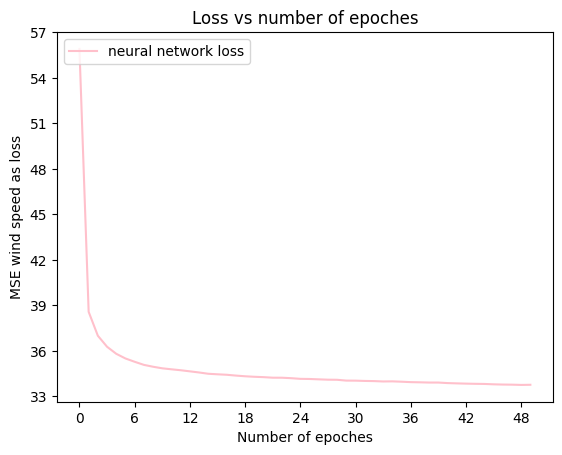

In [154]:
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(nn_loss, label='neural network loss', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')